# Slides

In [1]:
import os
import sys
import warnings
import numpy as np
import seaborn as sns

import matplotlib
matplotlib.rcParams['text.usetex'] = False

warnings.filterwarnings('ignore')
sys.path.insert(0, os.path.abspath(os.path.join(os.path.dirname('src'), '..')))

from src.constants import *
from src.visualize import *
from src.data import *

np.random.seed(42)

topological_error = ['ws', 'bn', 'l2pl', 'l2pi']
imputation_error = ['mae', 'rmse']

FIRST = [MANIFOLD, TIME_SERIES]
SECOND = [REGRESSION, CLASSIFICATION]

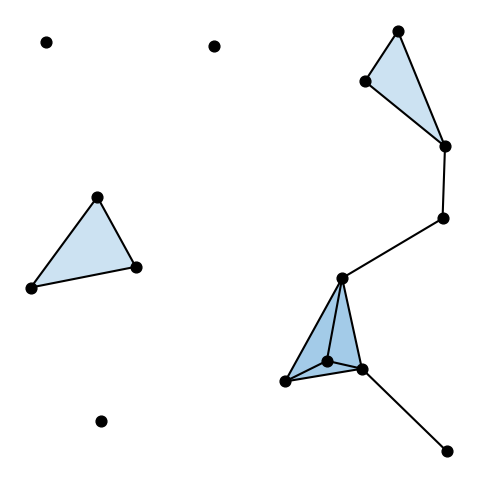

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import gudhi

np.random.seed(4)
num_points = 15
points = np.random.rand(num_points, 2)
epsilon = 0.3

def plot_rips_colored(points, epsilon, ax, margin=0.05):
    rips_complex = gudhi.RipsComplex(points=points, max_edge_length=epsilon)
    simplex_tree = rips_complex.create_simplex_tree(max_dimension=3)

    ax.scatter(points[:, 0], points[:, 1], c='black', s=60, zorder=3)

    for simplex, filt in simplex_tree.get_simplices():
        if filt > epsilon:
            continue
        if len(simplex) == 2:
            ax.plot(points[simplex, 0], points[simplex, 1], 'k-', linewidth=1.5, zorder=2)
        elif len(simplex) == 3:
            triangle = points[simplex]
            ax.fill(triangle[:, 0], triangle[:, 1], '#0070c0', alpha=0.2, zorder=1)

    ax.set_aspect('equal')
    ax.axis('off')

    x_min, x_max = points[:, 0].min(), points[:, 0].max()
    y_min, y_max = points[:, 1].min(), points[:, 1].max()
    x_range = x_max - x_min
    y_range = y_max - y_min
    ax.set_xlim(x_min - margin * x_range, x_max + margin * x_range)
    ax.set_ylim(y_min - margin * y_range, y_max + margin * y_range)

fig, ax = plt.subplots(figsize=(6, 6))
plot_rips_colored(points, epsilon, ax)
plt.show()
fig.savefig('../figures/slides/simplicial_complex.svg', format='svg', bbox_inches='tight')


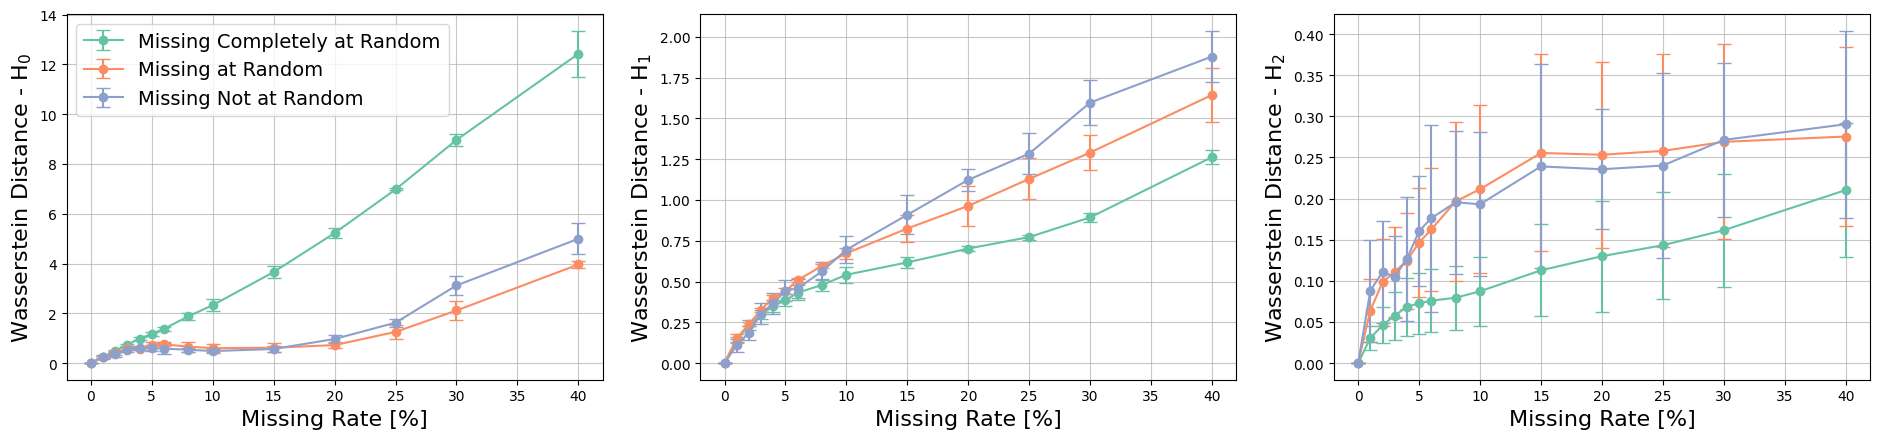

In [3]:
df = group_results(
    csv=IMPACT_MISSINGNESS,
    group=[DATASET, MISSINGNESS_TYPE, DIMENSION, MISSING_RATE],
    metrics=[WS],
    zeros=True
)
df_filtered = df[(df[DATASET].isin(COLLECTIONS[MANIFOLD]))].copy()

for m, metric in enumerate([WS]):
    fig, axes = setup_figure(
        rows=1,
        cols=len(DIMENSIONS)
    )
    axes = axes.flatten()

    for dim in DIMENSIONS:
        ax = axes[dim]
        
        for mt in COLLECTIONS[MISSINGNESS_TYPE]:
            mean, sem = compute_mean_sem(
                type=MISSINGNESS_TYPE,
                data=df_filtered,
                group=MISSING_RATE, 
                metric=metric,
                filter=(df_filtered[DIMENSION] == dim) & (df_filtered[MISSINGNESS_TYPE] == mt)
            )
            plot_data(
                type=MISSINGNESS_TYPE,
                ax=ax, mean=mean, sem=sem,
                label=LABEL[mt],
                color=plt.get_cmap(COLOR_MAP[MISSINGNESS_TYPE])(COLLECTIONS[MISSINGNESS_TYPE].index(mt))
            )

        format_axes(
            type=MISSINGNESS_TYPE, 
            ax=ax,
            x_label=LABEL[MISSING_RATE],
            y_label=f'{LABEL[metric]} - {LABEL[dim]}',
            legend=dim==0
        )

    plot(fig, f'../figures/slides/mt_manifold_ws.svg')

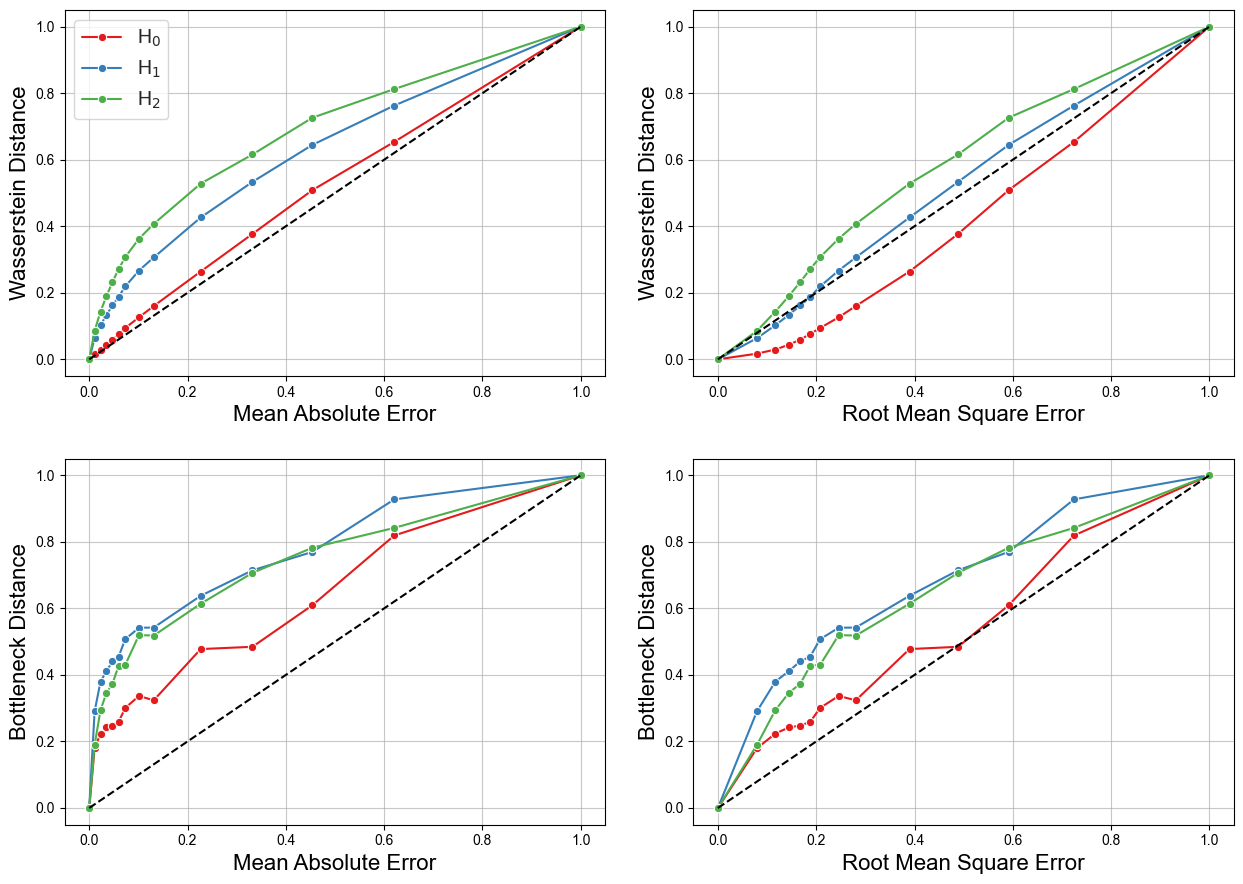

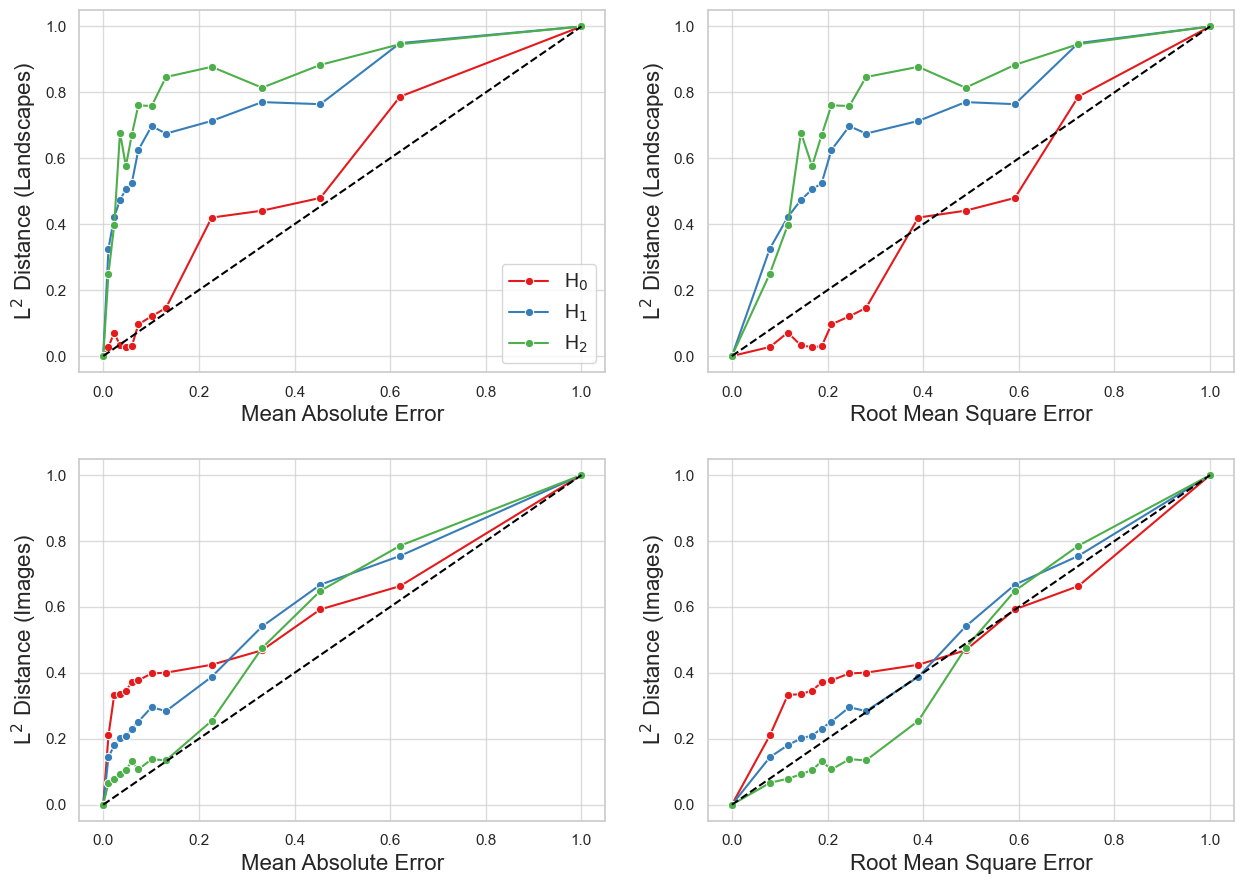

In [4]:
from sklearn.preprocessing import MinMaxScaler

def plot_vs_imputatian_error(filename, scaler, filter=None, mt=MAR, tda_metrics=COLLECTIONS[TDA_METRIC]):
    df_comp = pd.read_csv(COMPARISON_METRICS)
    df_comp = (
        df_comp
        .loc[lambda df: (df[IMPUTATION_METHOD] == KNN) & (df[MISSINGNESS_TYPE] == mt)]
        .groupby([MISSING_RATE])[COLLECTIONS[METRIC]]
        .mean()
        .reset_index()
        .melt(
            id_vars=[MISSING_RATE],
            value_vars=COLLECTIONS[METRIC],
            var_name=METRIC,
            value_name=DISTANCE
        )
    )
    zeros_comp = (
        df_comp[[METRIC]]
        .drop_duplicates()
        .assign(**{MISSING_RATE: 0, DISTANCE: 0.0})
    )
    df_comp = pd.concat([df_comp, zeros_comp], ignore_index=True).sort_values([METRIC, MISSING_RATE])
    df_comp[SCALED_DISTANCE] = (
        df_comp
        .groupby(METRIC)[DISTANCE]
        .transform(lambda x: scaler.fit_transform(x.values.reshape(-1,1)).ravel())
    )
    df_comp[NORMALIZED_DISTANCE] = (
        df_comp
        .groupby([METRIC])[SCALED_DISTANCE]
        .transform(lambda x: x / x.max() if x.max() != 0 else 0)
    )

    df_tda = pd.read_csv(IMPACT_MISSINGNESS)
    if filter is not None:
        df_tda = df_tda[df_tda[DATASET].isin(filter)]
    df_tda = (
        df_tda
        .loc[lambda df: (df[IMPUTATION_METHOD] == KNN) & (df[MISSINGNESS_TYPE] == mt)]
        .groupby([DIMENSION, MISSING_RATE])[COLLECTIONS[TDA_METRIC]]
        .mean()
        .reset_index()
        .melt(
            id_vars=[DIMENSION, MISSING_RATE],
            value_vars=COLLECTIONS[TDA_METRIC],
            var_name=METRIC,
            value_name=DISTANCE
        )
    )
    zeros_tda = (
        df_tda[[DIMENSION, METRIC]]
        .drop_duplicates()
        .assign(**{MISSING_RATE: 0, DISTANCE: 0.0})
    )
    df_tda = pd.concat([df_tda, zeros_tda], ignore_index=True).sort_values([METRIC, DIMENSION, MISSING_RATE])
    df_tda[SCALED_DISTANCE] = (
        df_tda
        .groupby(METRIC)[DISTANCE]
        .transform(lambda x: scaler.fit_transform(x.values.reshape(-1,1)).ravel())
    )
    df_tda[NORMALIZED_DISTANCE] = (
        df_tda
        .groupby([METRIC, DIMENSION])[SCALED_DISTANCE]
        .transform(lambda x: x / x.max() if x.max() != 0 else 0)
    )

    merged_list = []
    for tda_metric in COLLECTIONS[TDA_METRIC]:
        for metric in COLLECTIONS[METRIC]:
            classical_df = df_comp[df_comp[METRIC] == metric][[MISSING_RATE, NORMALIZED_DISTANCE]].rename(columns={NORMALIZED_DISTANCE: 'COMP'})
            tda_df = df_tda[df_tda[METRIC] == tda_metric][[DIMENSION, MISSING_RATE, NORMALIZED_DISTANCE]].rename(columns={NORMALIZED_DISTANCE: 'TDA'})

            merged = tda_df.merge(classical_df, on=MISSING_RATE)
            merged[TDA_ERROR] = tda_metric
            merged[COMP_ERROR] = metric
            merged_list.append(merged)

    df_merged_all = pd.concat(merged_list, ignore_index=True)
    df_long = df_merged_all.melt(
        id_vars=[DIMENSION, MISSING_RATE, TDA_ERROR, COMP_ERROR],
        value_vars=['COMP', 'TDA'],
        var_name=DATASET_TYPE,
        value_name=NORMALIZED_DISTANCE
    )
    pivoted = (
        df_long
        .pivot_table(
            index=[DIMENSION, MISSING_RATE, TDA_ERROR, COMP_ERROR],
            columns=DATASET_TYPE,
            values=NORMALIZED_DISTANCE
        )
        .reset_index()
        .dropna()
    )

    fig, axes = setup_figure(
        rows=len(tda_metrics), 
        cols=len(COLLECTIONS[METRIC])
    )
    sns.set(style="whitegrid")

    for i, tda_metric in enumerate(tda_metrics):
        for j, comp_metric in enumerate(COLLECTIONS[METRIC]):
            ax = axes[i][j]
            subset = pivoted[(pivoted[TDA_ERROR] == tda_metric) & (pivoted[COMP_ERROR] == comp_metric)]
        
            for dim in DIMENSIONS:
                dim_data = subset[subset[DIMENSION] == dim]
                sns.lineplot(
                    data=dim_data,
                    x='COMP',
                    y='TDA',
                    ax=ax,
                    marker='o',
                    label=LABEL[dim],
                    color=sns.color_palette(COLOR_MAP[DIMENSION], n_colors=len(DIMENSIONS))[dim],
                    legend=False
                )
            
            format_axes(
                type=MISSING_RATE,
                ax=ax,
                x_label=LABEL[comp_metric],
                y_label=LABEL[tda_metric],
                legend=(i==0 and j==0)
            )
            ax.plot([0, 1], [0, 1], linestyle='--', color='black')

    plot(fig, filename)

plot_vs_imputatian_error('../figures/slides/tda_vs_imp_1.svg', MinMaxScaler(), tda_metrics=COLLECTIONS[TDA_METRIC_SHORT])
plot_vs_imputatian_error('../figures/slides/tda_vs_imp_2.svg', MinMaxScaler(), tda_metrics=[x for x in COLLECTIONS[TDA_METRIC] if x not in COLLECTIONS[TDA_METRIC_SHORT]])

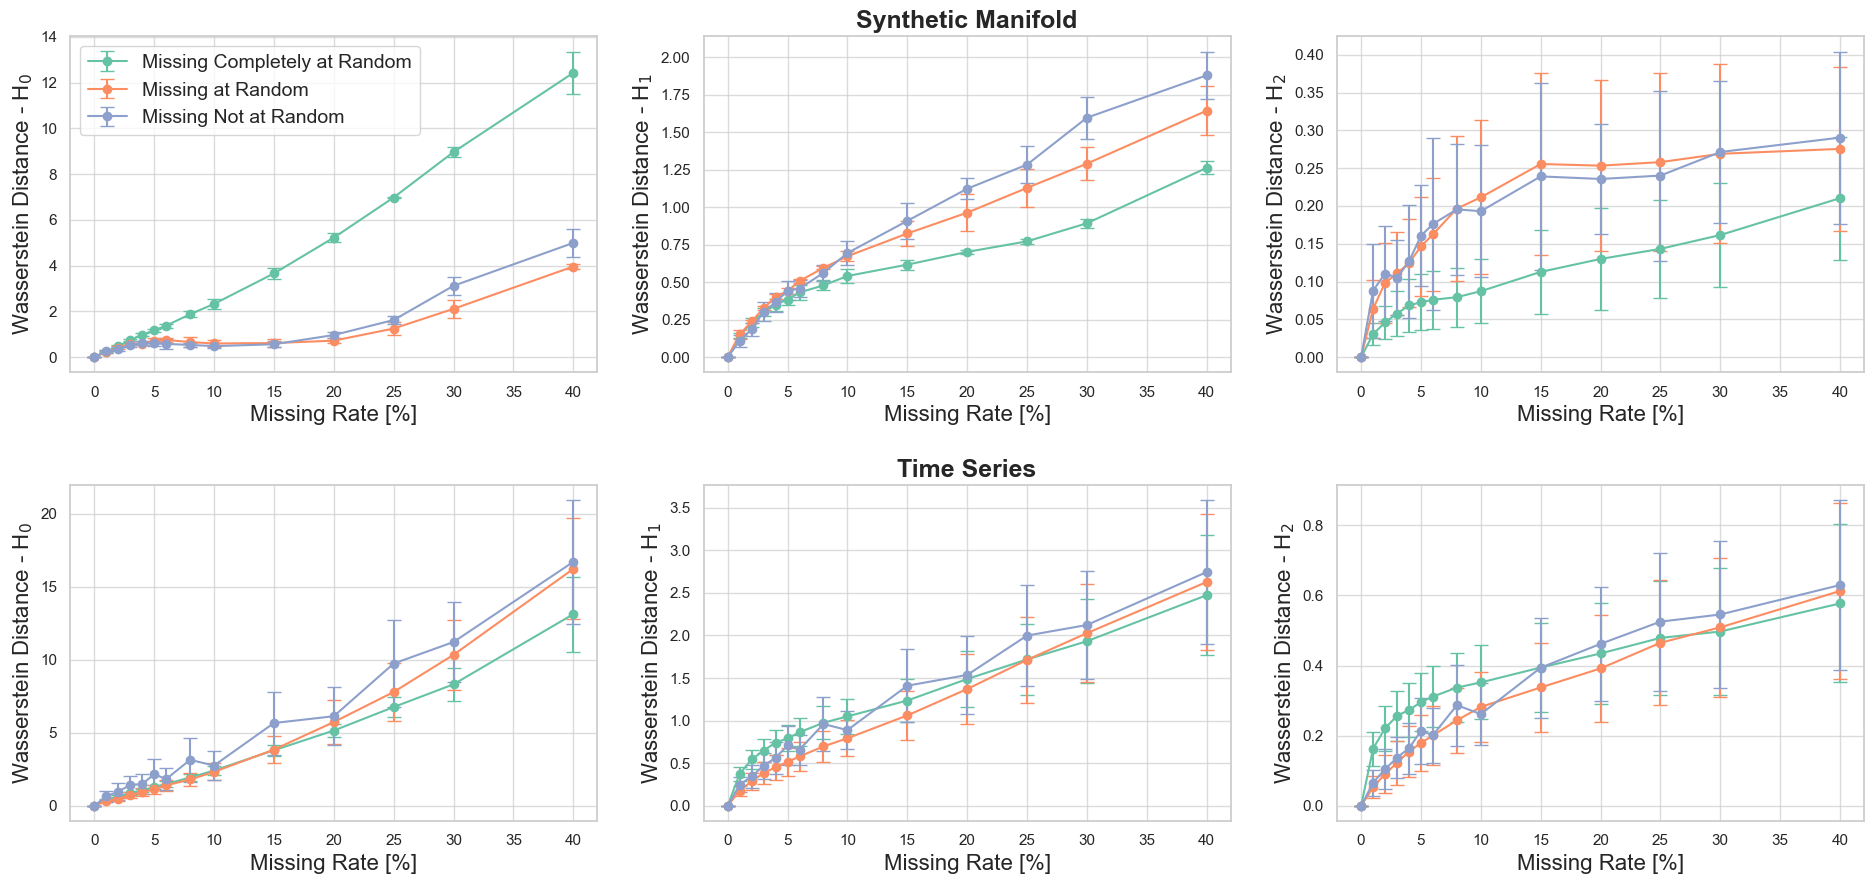

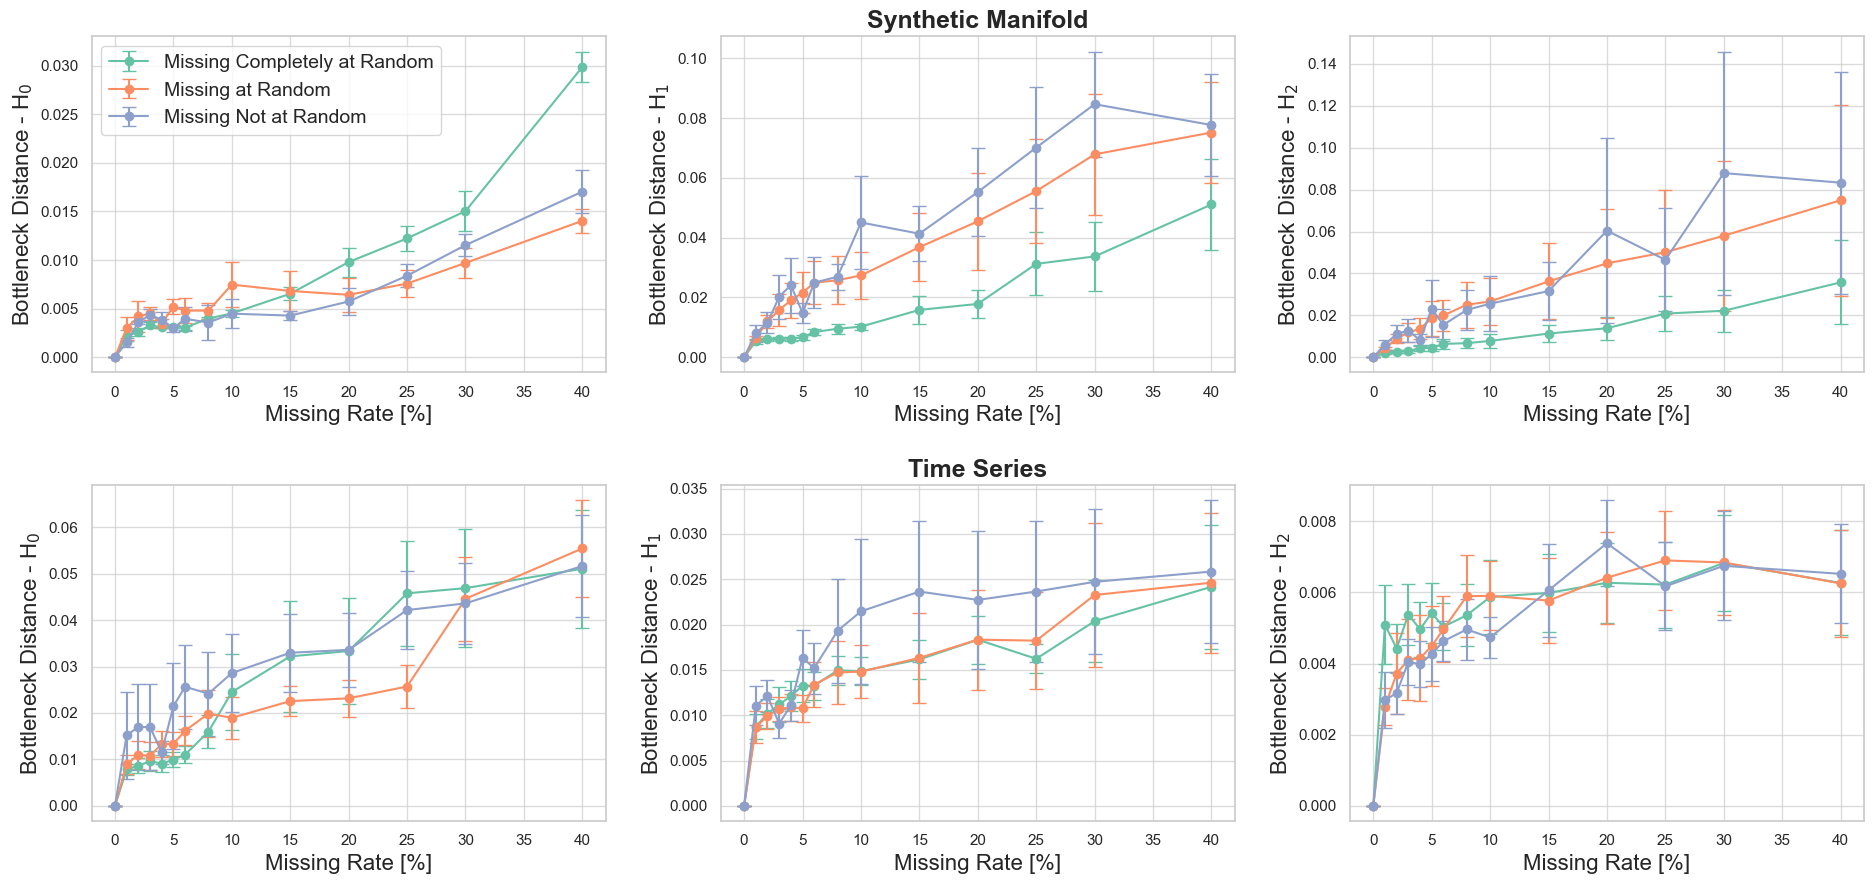

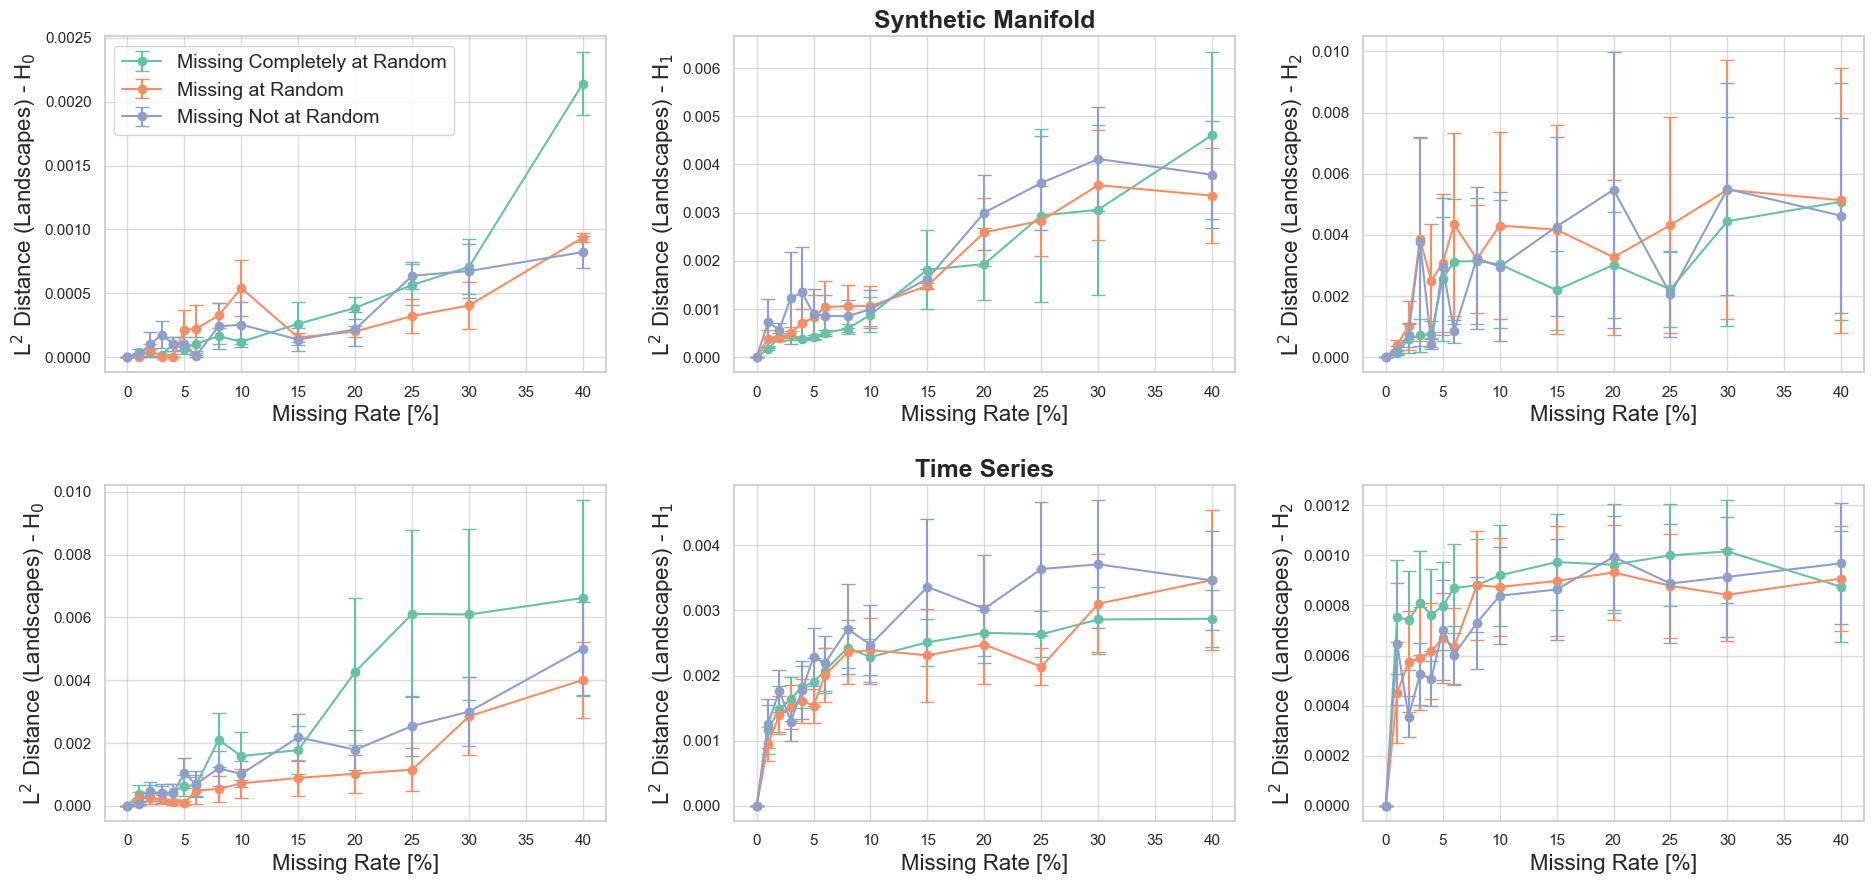

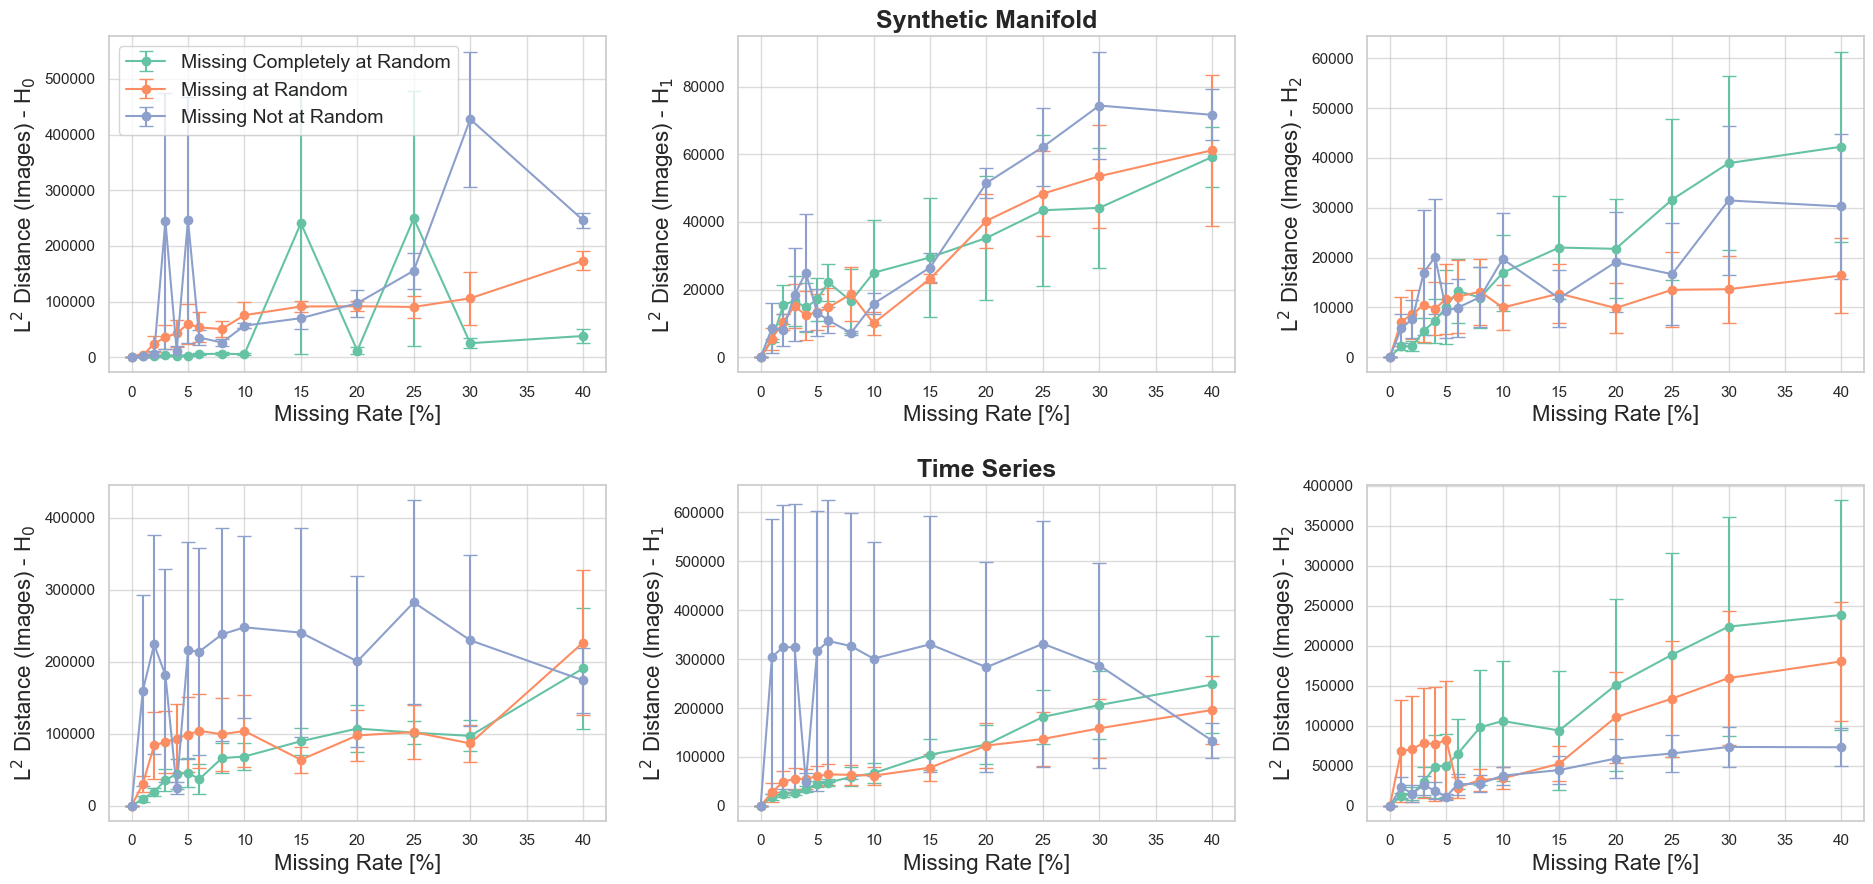

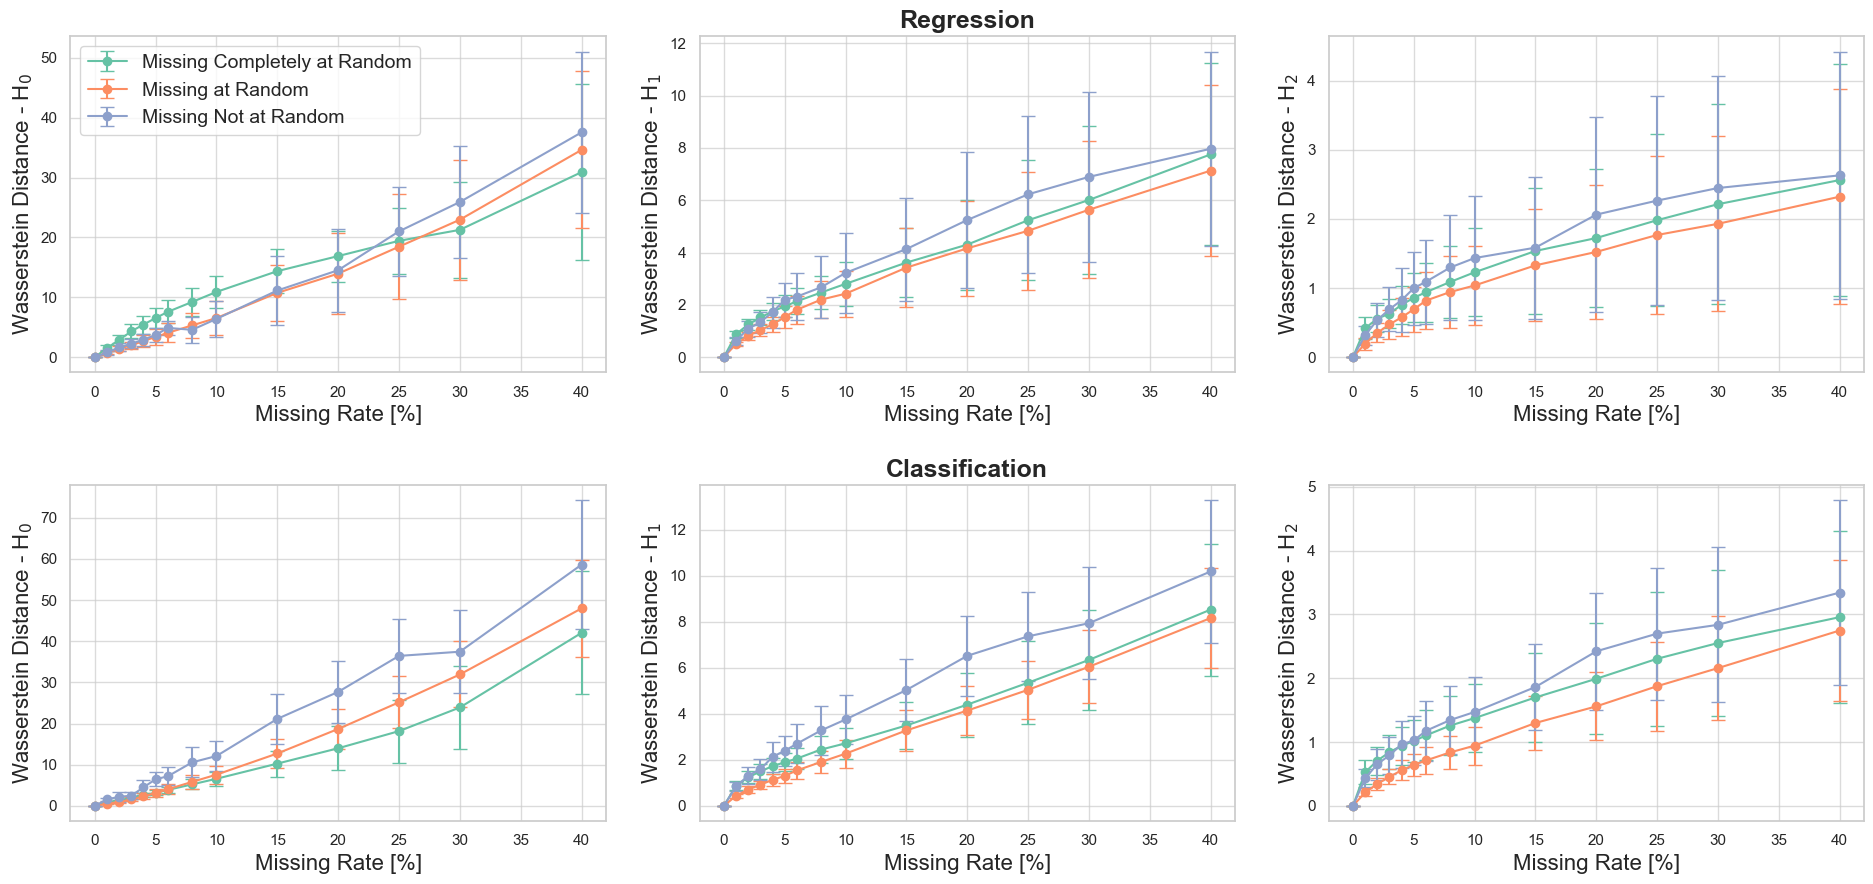

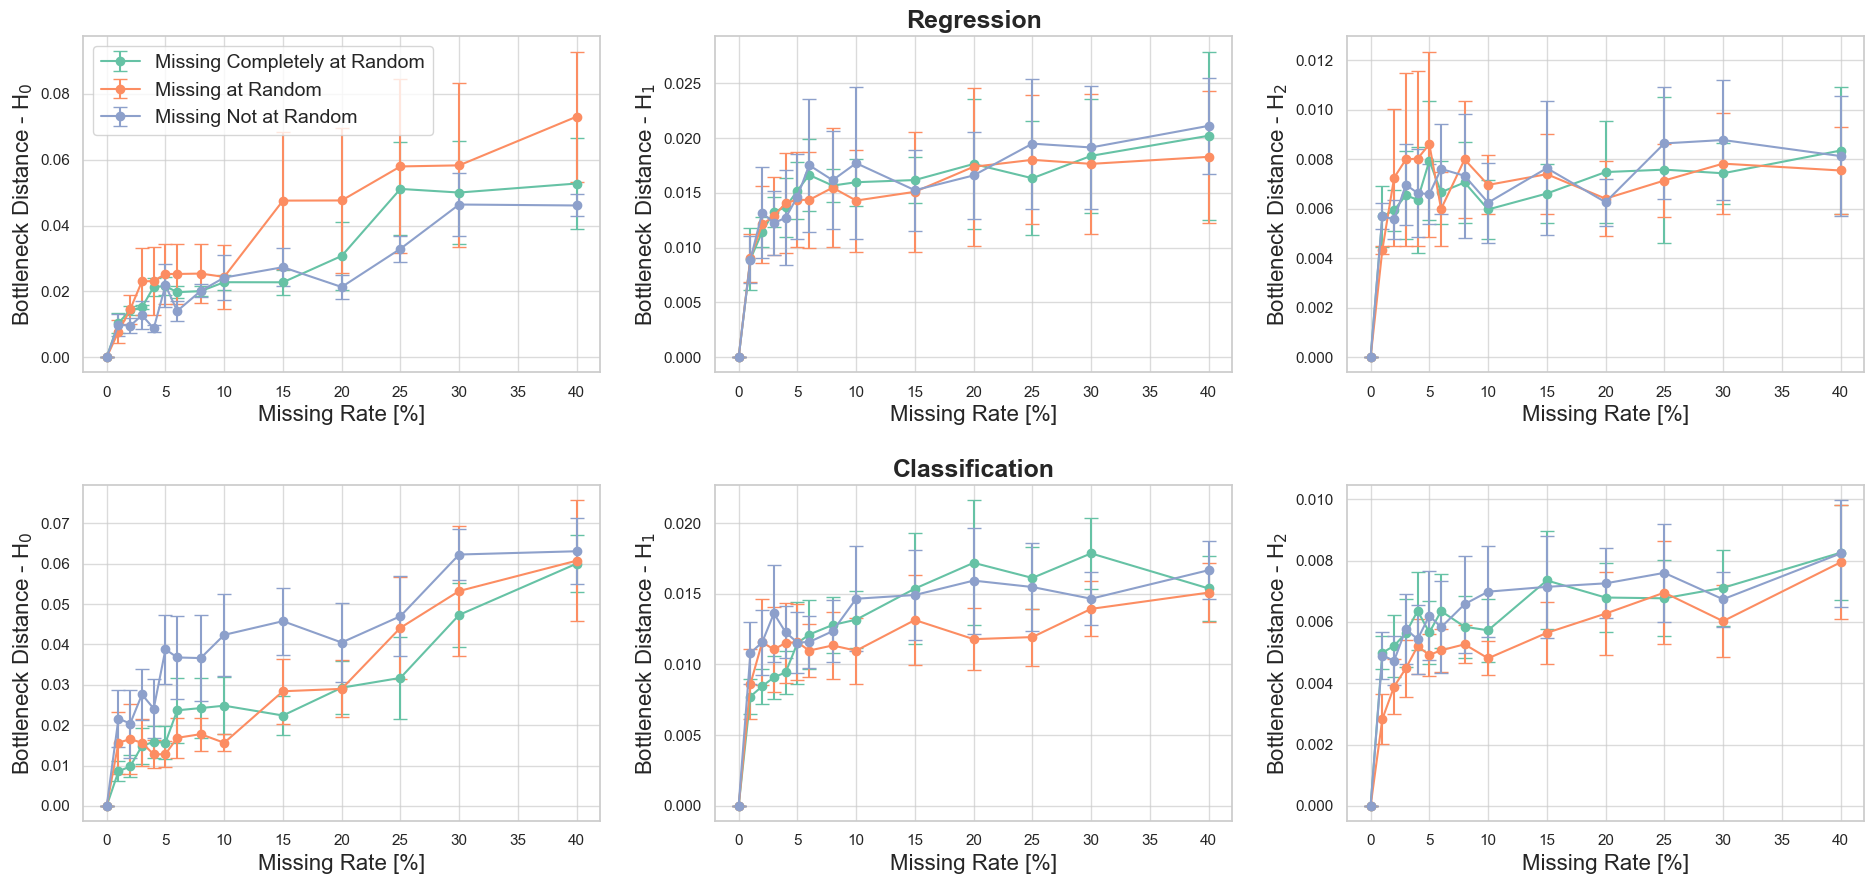

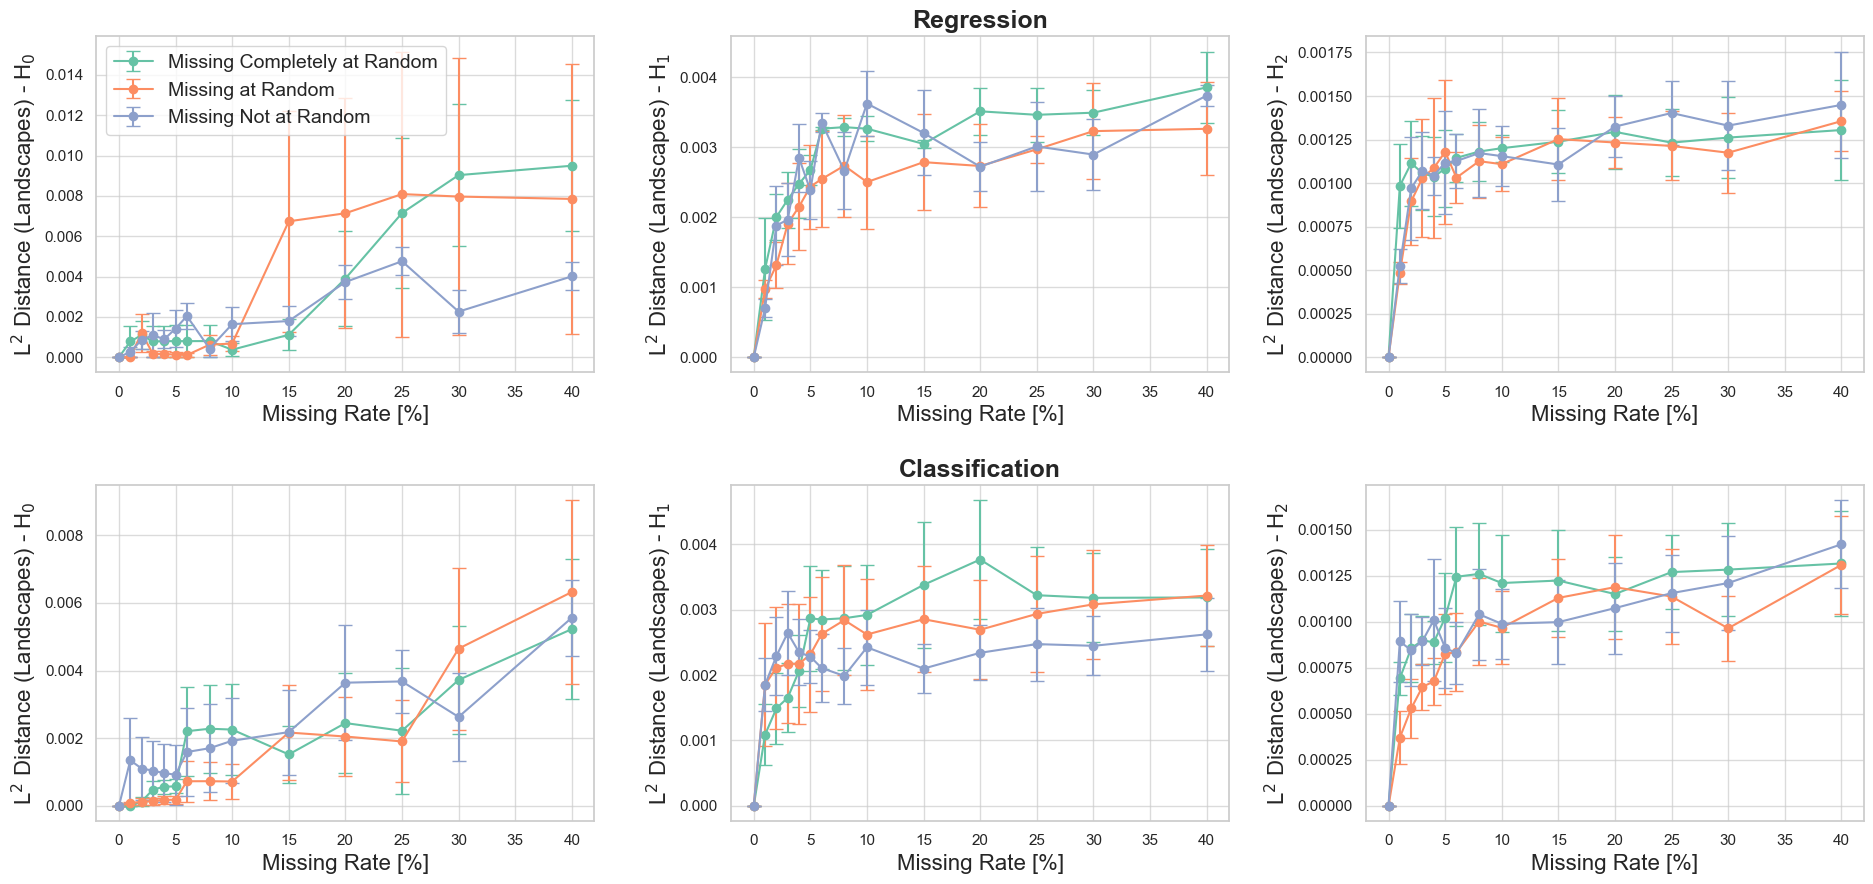

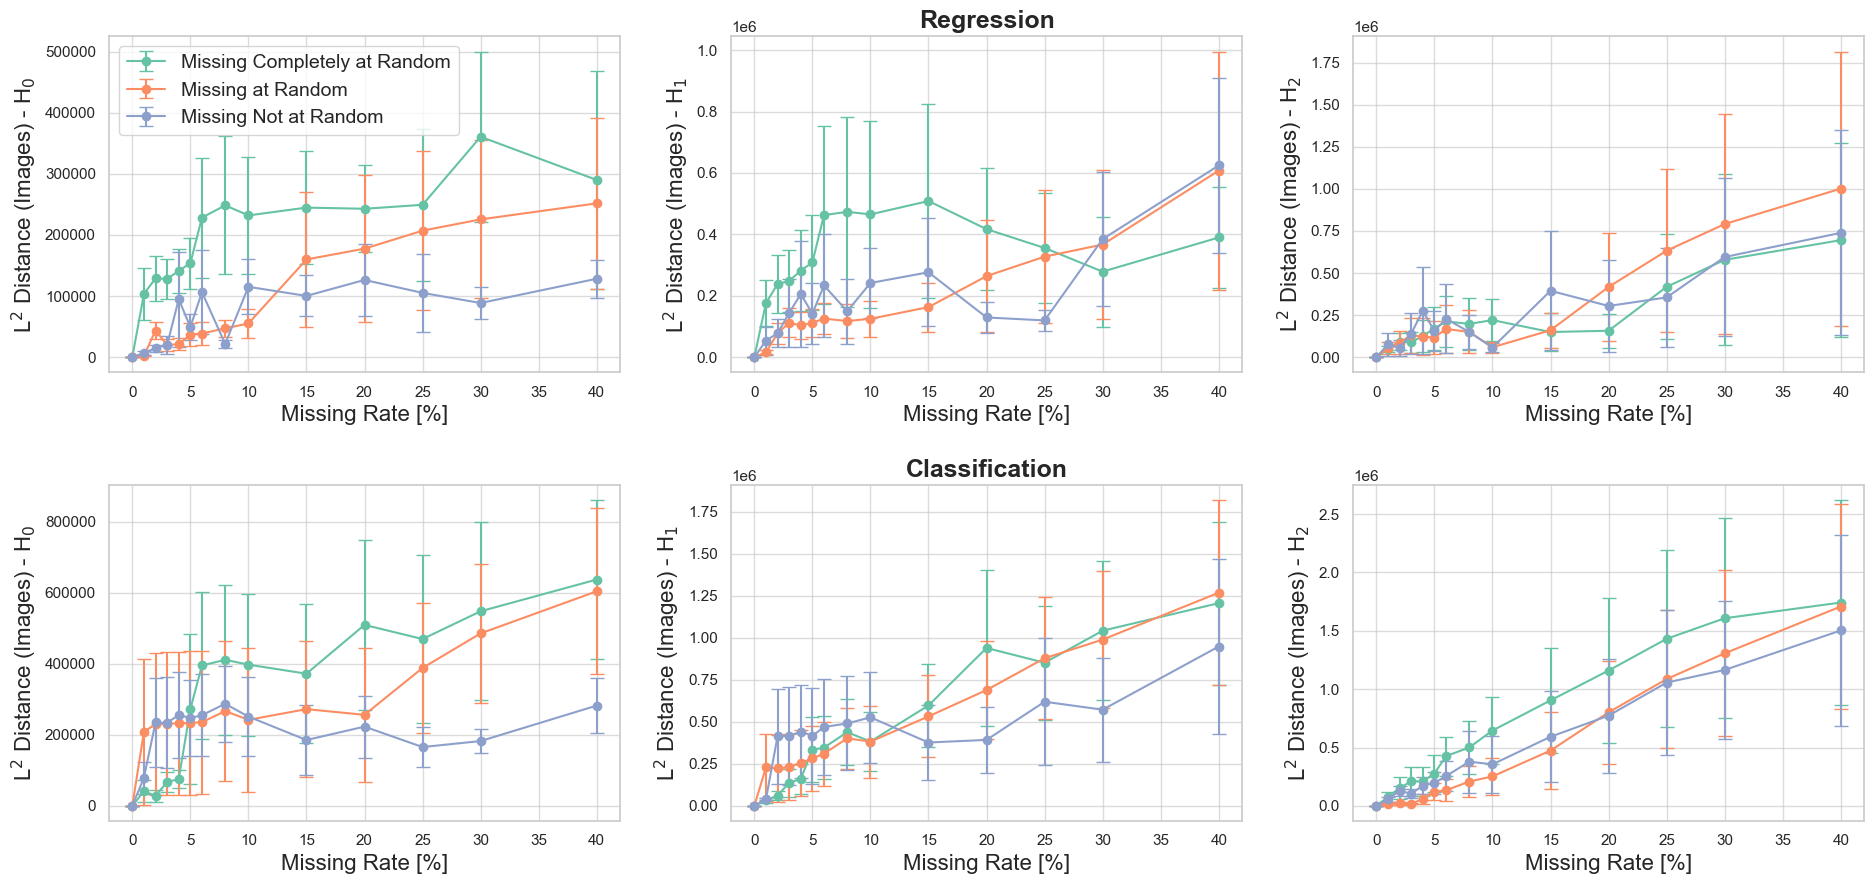

In [5]:
def mt(dataset_types, suffix):
    df = group_results(
        csv=IMPACT_MISSINGNESS,
        group=[DATASET, MISSINGNESS_TYPE, DIMENSION, MISSING_RATE],
        metrics=COLLECTIONS[TDA_METRIC],
        zeros=True
    )

    for m, metric in enumerate(COLLECTIONS[TDA_METRIC]):
        fig, axes = setup_figure(
            rows=len(dataset_types),
            cols=len(DIMENSIONS)
        )

        for i, dataset_type in enumerate(dataset_types):
            df_filtered = df[(df[DATASET].isin(COLLECTIONS[dataset_type]))].copy()        
            for dim in DIMENSIONS:
                ax = axes[i][dim]
                for mt in COLLECTIONS[MISSINGNESS_TYPE]:
                    mean, sem = compute_mean_sem(
                        type=MISSINGNESS_TYPE,
                        data=df_filtered,
                        group=MISSING_RATE, 
                        metric=metric,
                        filter=(df_filtered[DIMENSION] == dim) & (df_filtered[MISSINGNESS_TYPE] == mt)
                    )
                    plot_data(
                        type=MISSINGNESS_TYPE,
                        ax=ax, mean=mean, sem=sem,
                        label=LABEL[mt],
                        color=plt.get_cmap(COLOR_MAP[MISSINGNESS_TYPE])(COLLECTIONS[MISSINGNESS_TYPE].index(mt))
                    )

                format_axes(
                    type=MISSINGNESS_TYPE, 
                    ax=ax,
                    x_label=LABEL[MISSING_RATE],
                    y_label=f'{LABEL[metric]} - {LABEL[dim]}',
                    legend=i==0 and dim==0,
                    title=dim==1,
                    title_label=LABEL[dataset_type]
                )

        plot(fig, f'../figures/slides/mt_dataset_{topological_error[m]}{suffix}.svg')

mt(FIRST, '_1')
mt(SECOND, '_2')

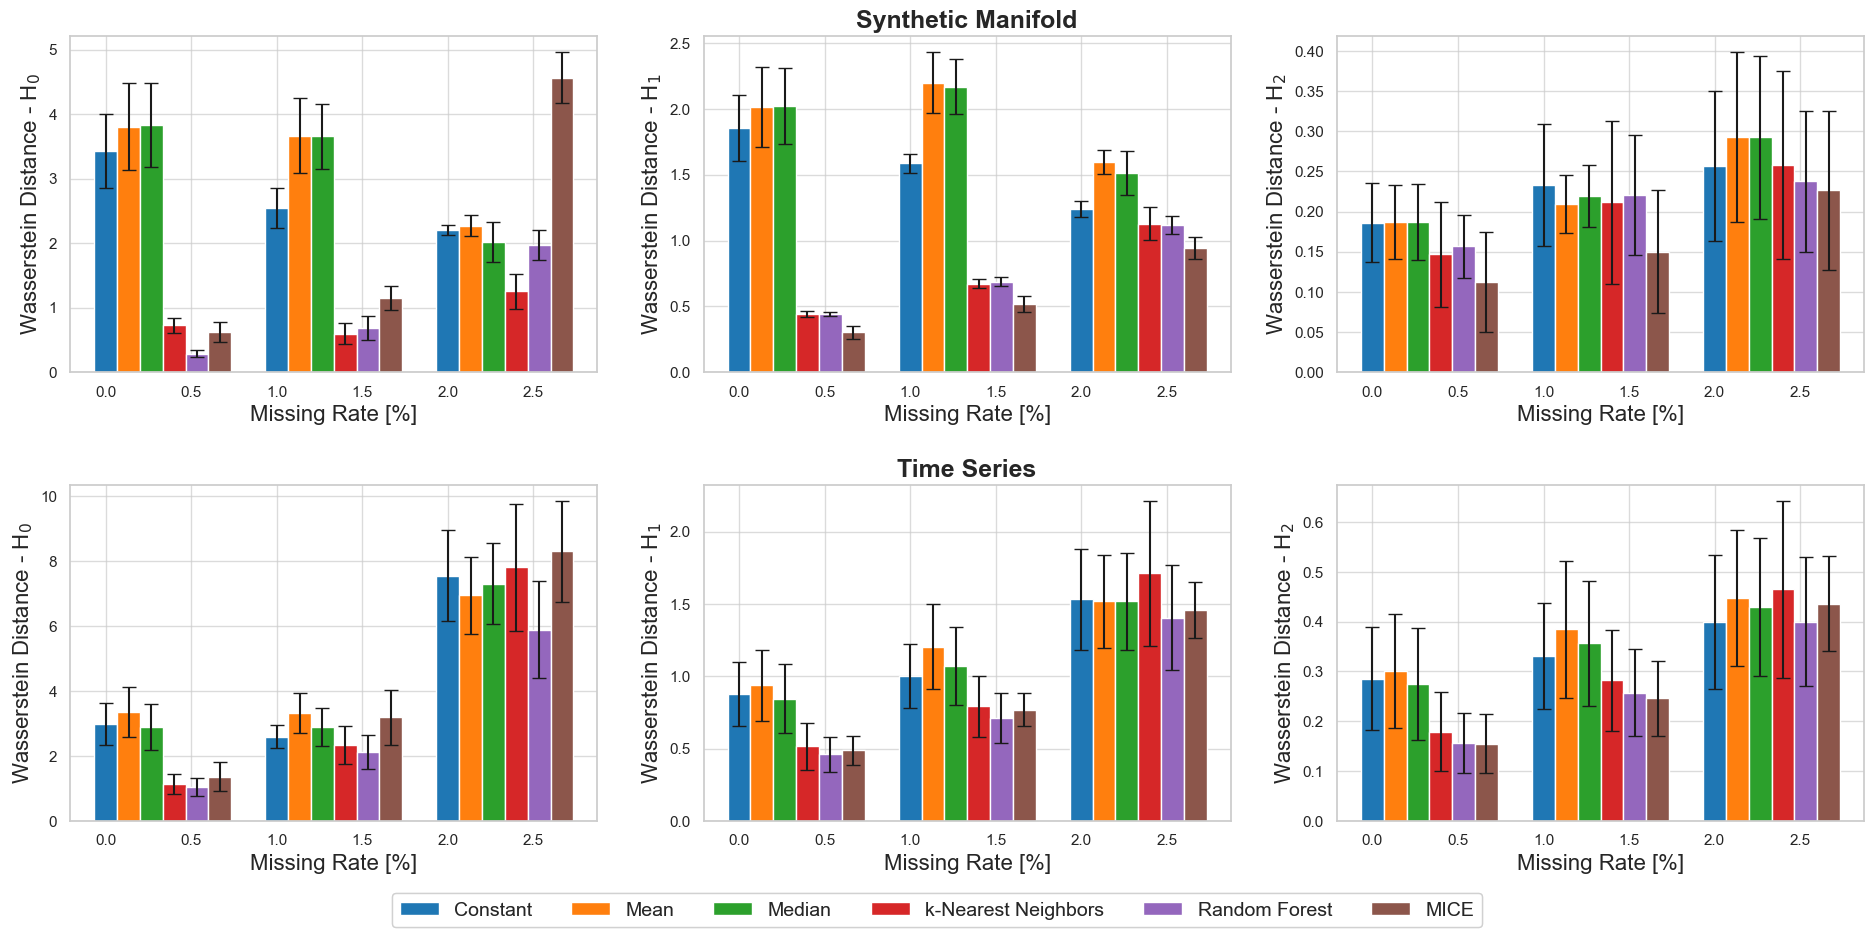

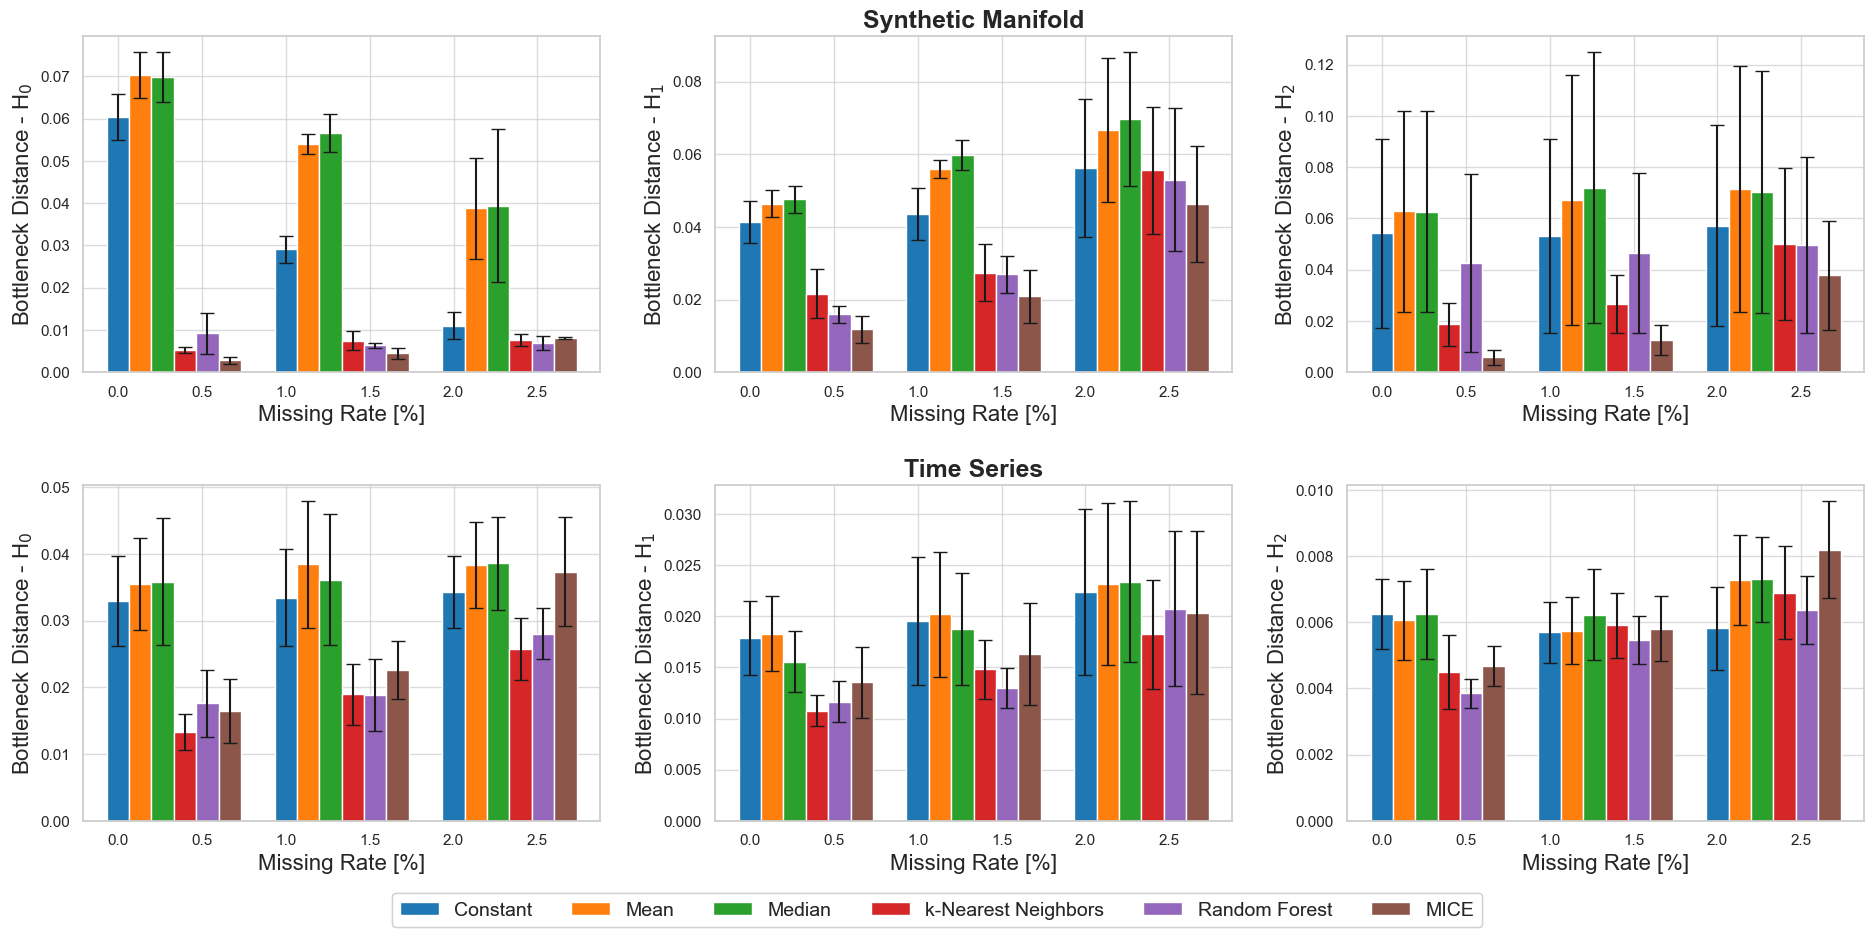

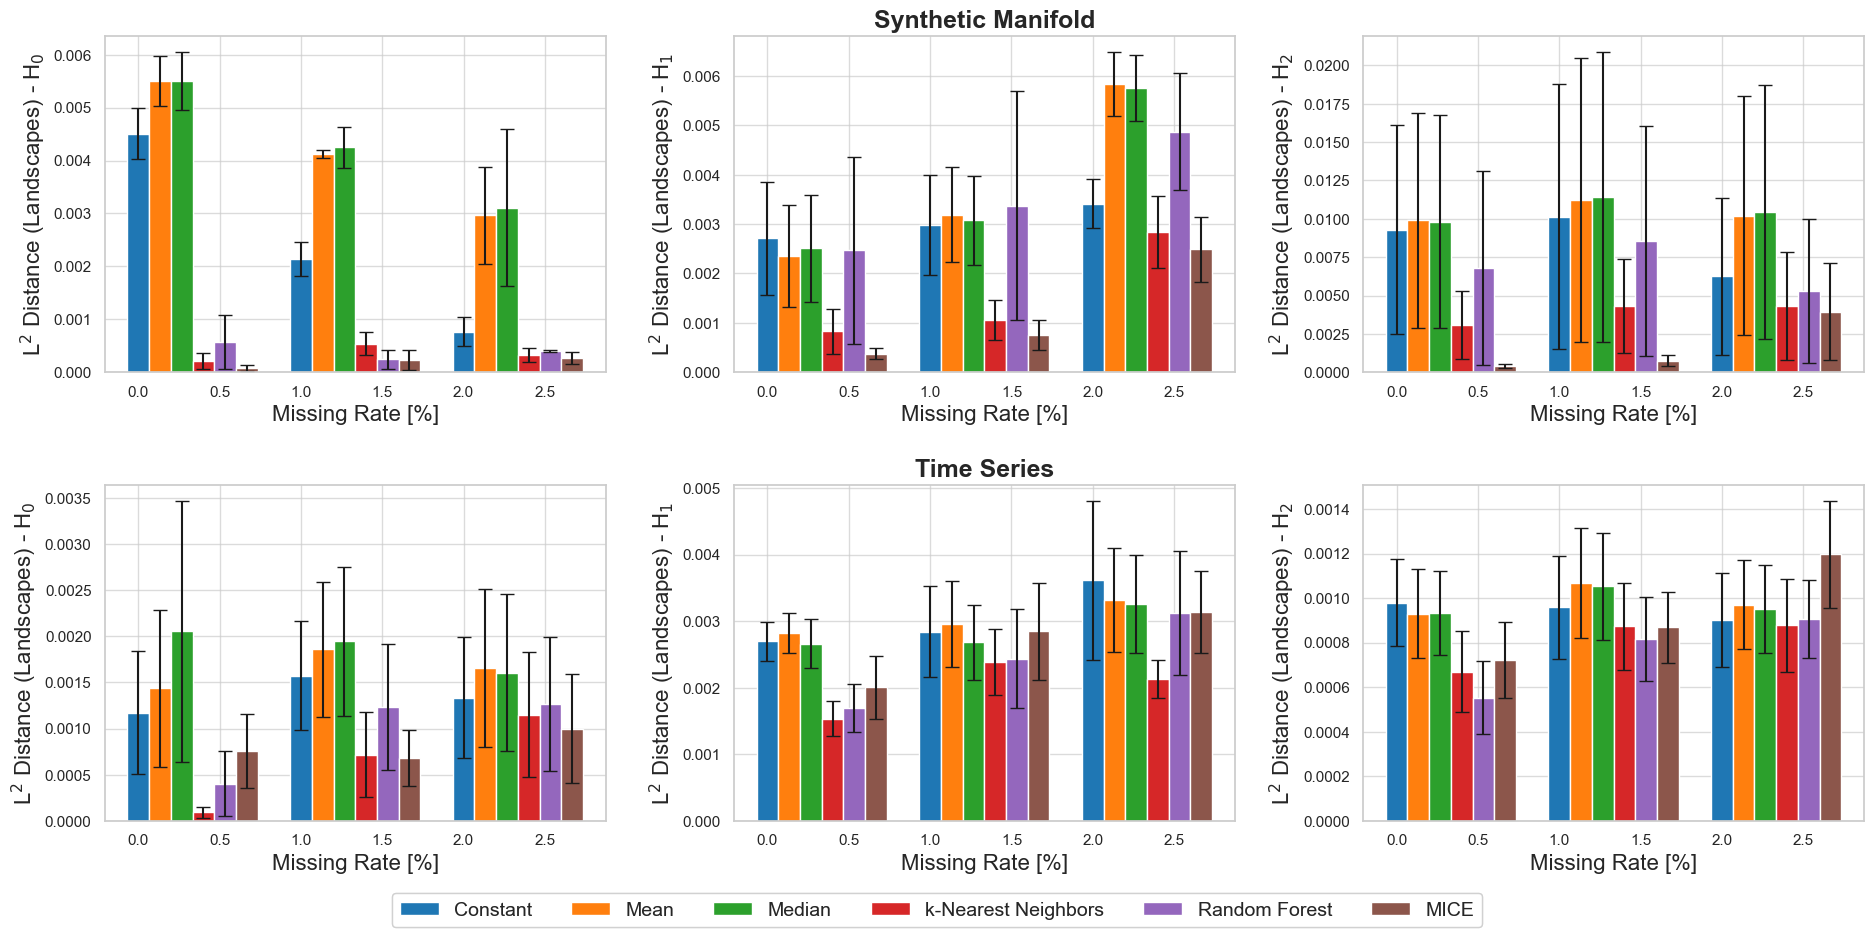

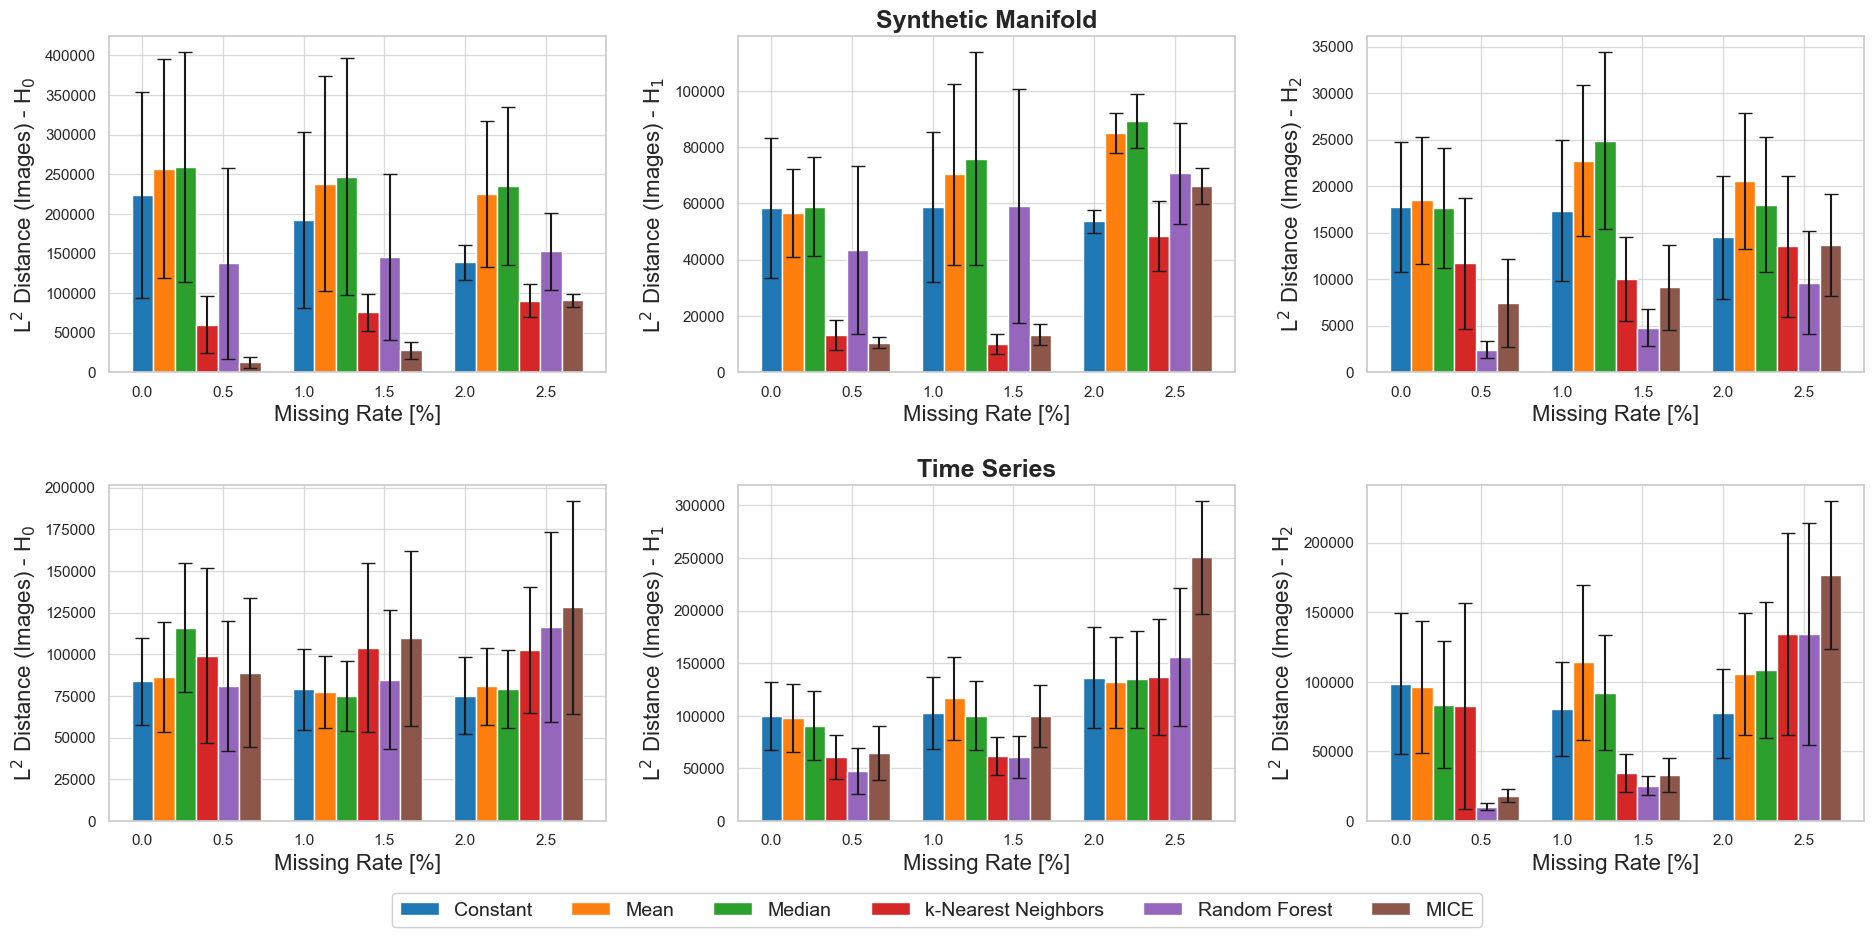

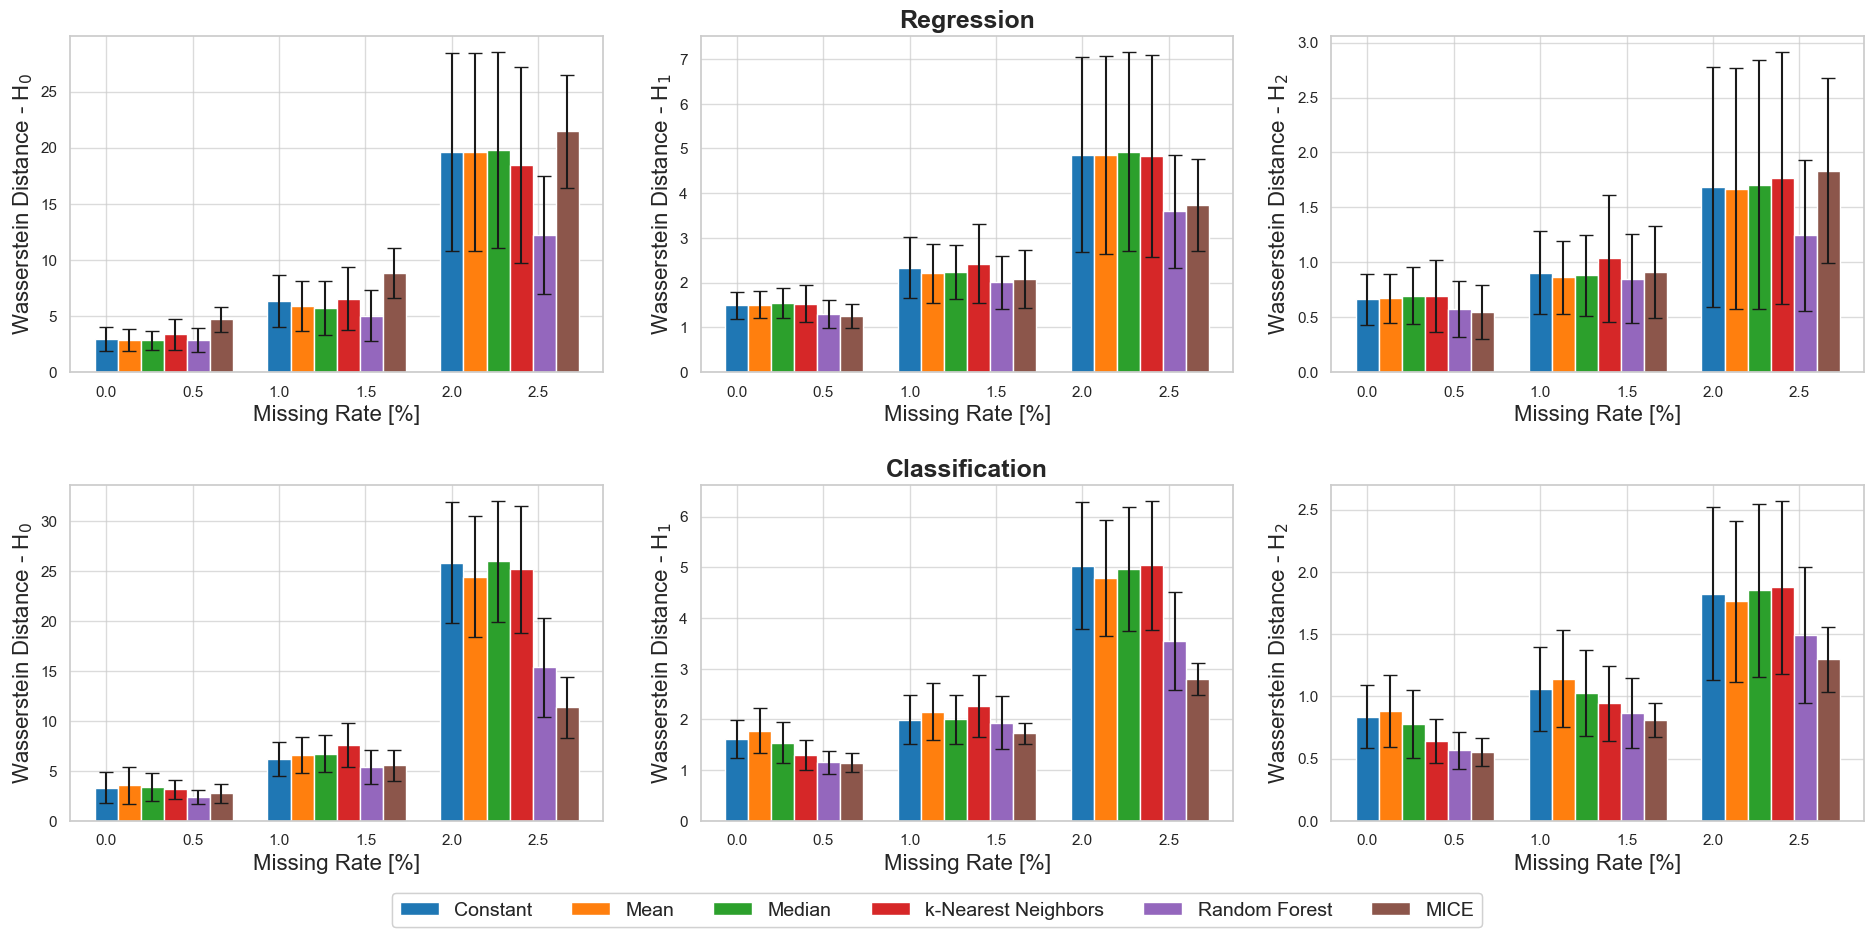

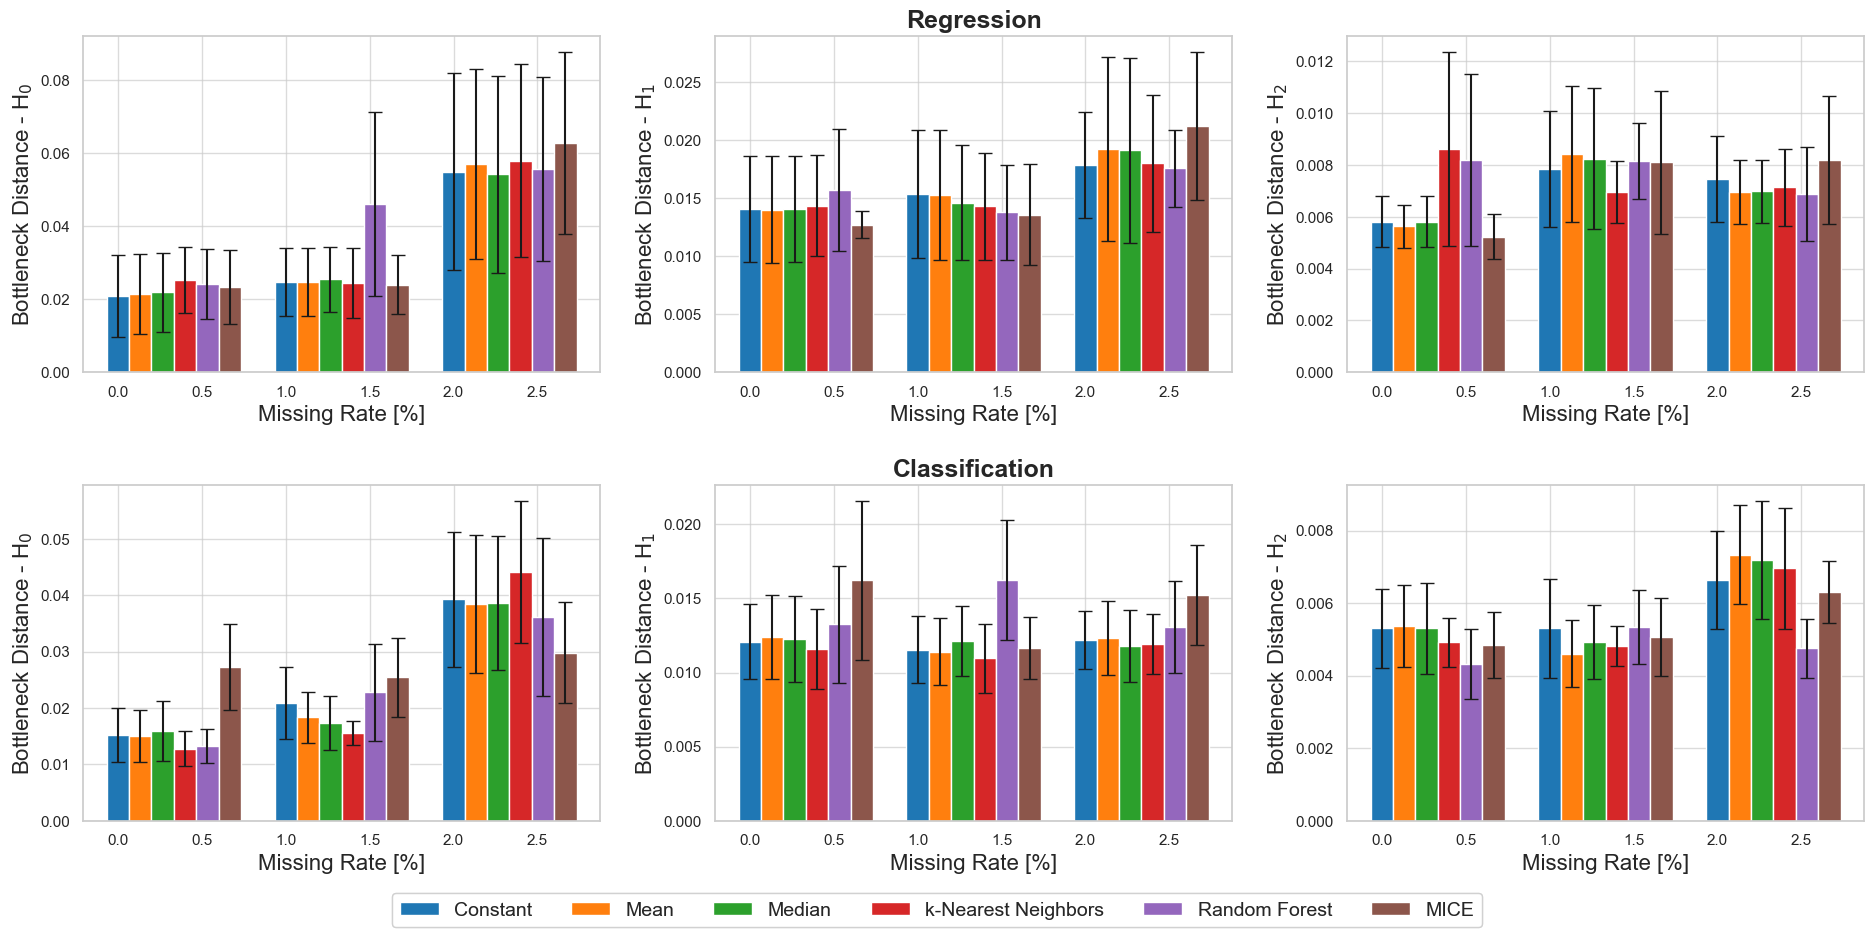

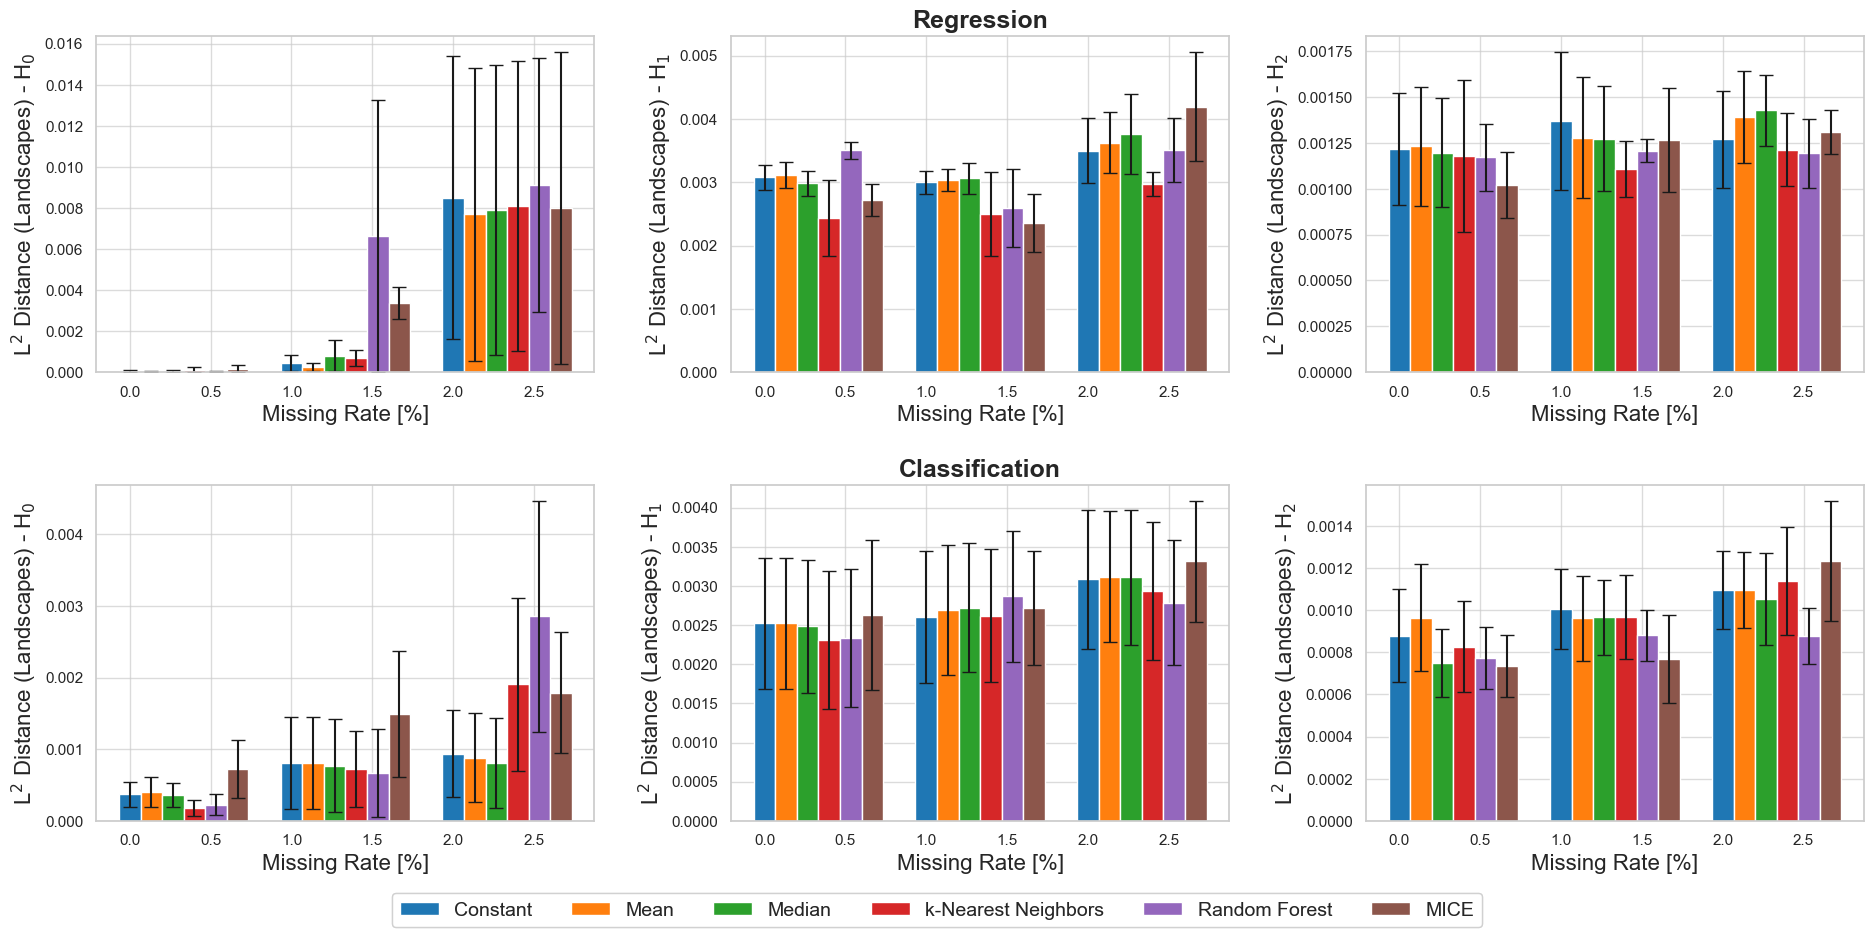

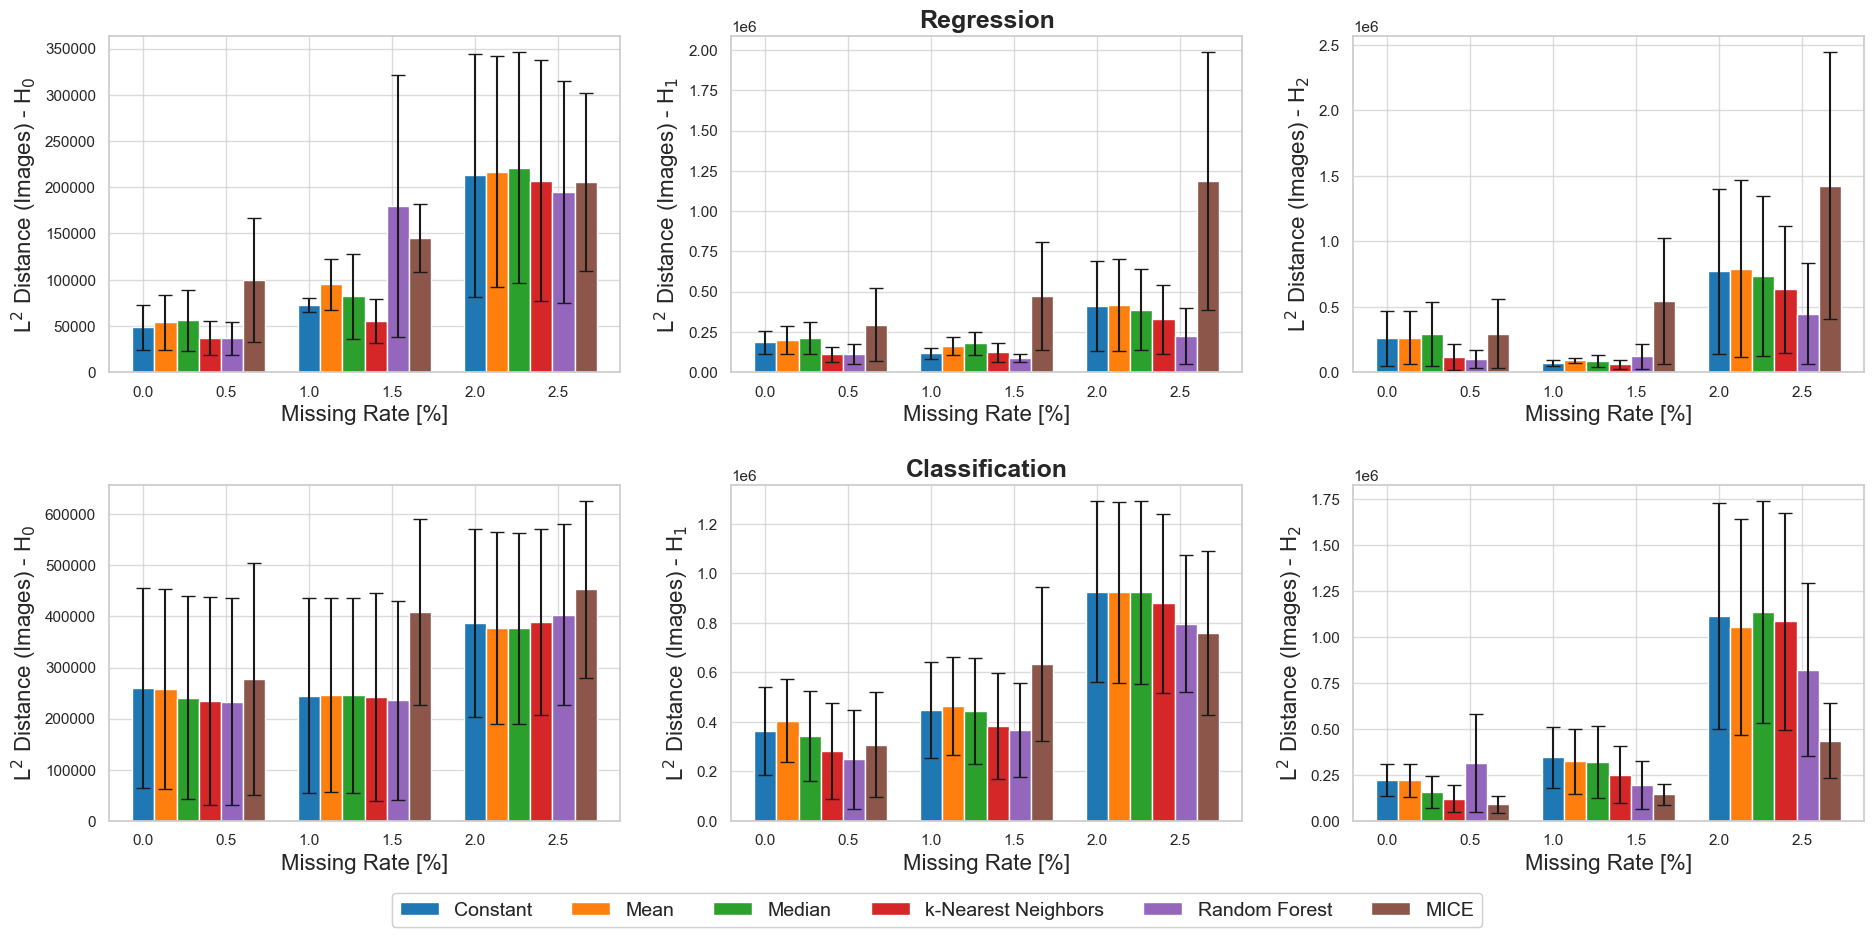

In [6]:
def imp(dataset_types, suffix):
    df = group_results(
        csv=IMPACT_IMPUTATION,
        group=[DATASET, IMPUTATION_METHOD, DIMENSION, MISSING_RATE],
        metrics=COLLECTIONS[TDA_METRIC]
    )

    for m, metric in enumerate(COLLECTIONS[TDA_METRIC]):
        fig, axes = setup_figure(
            rows=len(dataset_types),
            cols=len(DIMENSIONS)
        )

        for i, dataset_type in enumerate(dataset_types):
            df_filtered = df[df[DATASET].isin(COLLECTIONS[dataset_type])].copy()

            for dim in DIMENSIONS:
                ax = axes[i][dim]
                df_stats, x, width = boxplot_stats(
                    df=df_filtered, 
                    filter=df_filtered[DIMENSION] == dim, 
                    group=[MISSING_RATE, IMPUTATION_METHOD], 
                    metric=metric,
                    steps=COLLECTIONS[MISSING_RATE], 
                    ticks=COLLECTIONS[IMPUTATION_METHOD]
                )

                for j, imp in enumerate(COLLECTIONS[IMPUTATION_METHOD]):
                    mean, sem = compute_mean_sem(
                        type=IMPUTATION_METHOD,
                        data=df_stats,
                        group=MISSING_RATE,
                        filter=df_stats[IMPUTATION_METHOD] == imp
                    )

                    format_axes(
                        type=MISSINGNESS_TYPE, 
                        ax=ax,
                        x_label=LABEL[MISSING_RATE],
                        y_label=f'{LABEL[metric]} - {LABEL[dim]}',
                        ticks=x + width*(len(COLLECTIONS[IMPUTATION_METHOD])-1)/2,
                        tick_labels=COLLECTIONS[MISSING_RATE],
                        title=dim==1,
                        title_label=LABEL[dataset_type]
                    )
                    plot_data(
                        type=IMPUTATION_METHOD,
                        ax=ax, mean=mean, sem=sem,
                        label=LABEL[imp],
                        color=plt.get_cmap(COLOR_MAP[IMPUTATION_METHOD])(COLLECTIONS[IMPUTATION_METHOD].index(imp)),
                        x=x+j*width,
                        width=width
                    )

            legend(
                axes=axes[0],
                fig=fig, 
                cols=len(COLLECTIONS[IMPUTATION_METHOD]),
                bbox=(0.5, -0.05)
            )

        plot(fig, f'../figures/slides/imp_dataset_{topological_error[m]}{suffix}.svg')

imp(FIRST, '_1')
imp(SECOND, '_2')

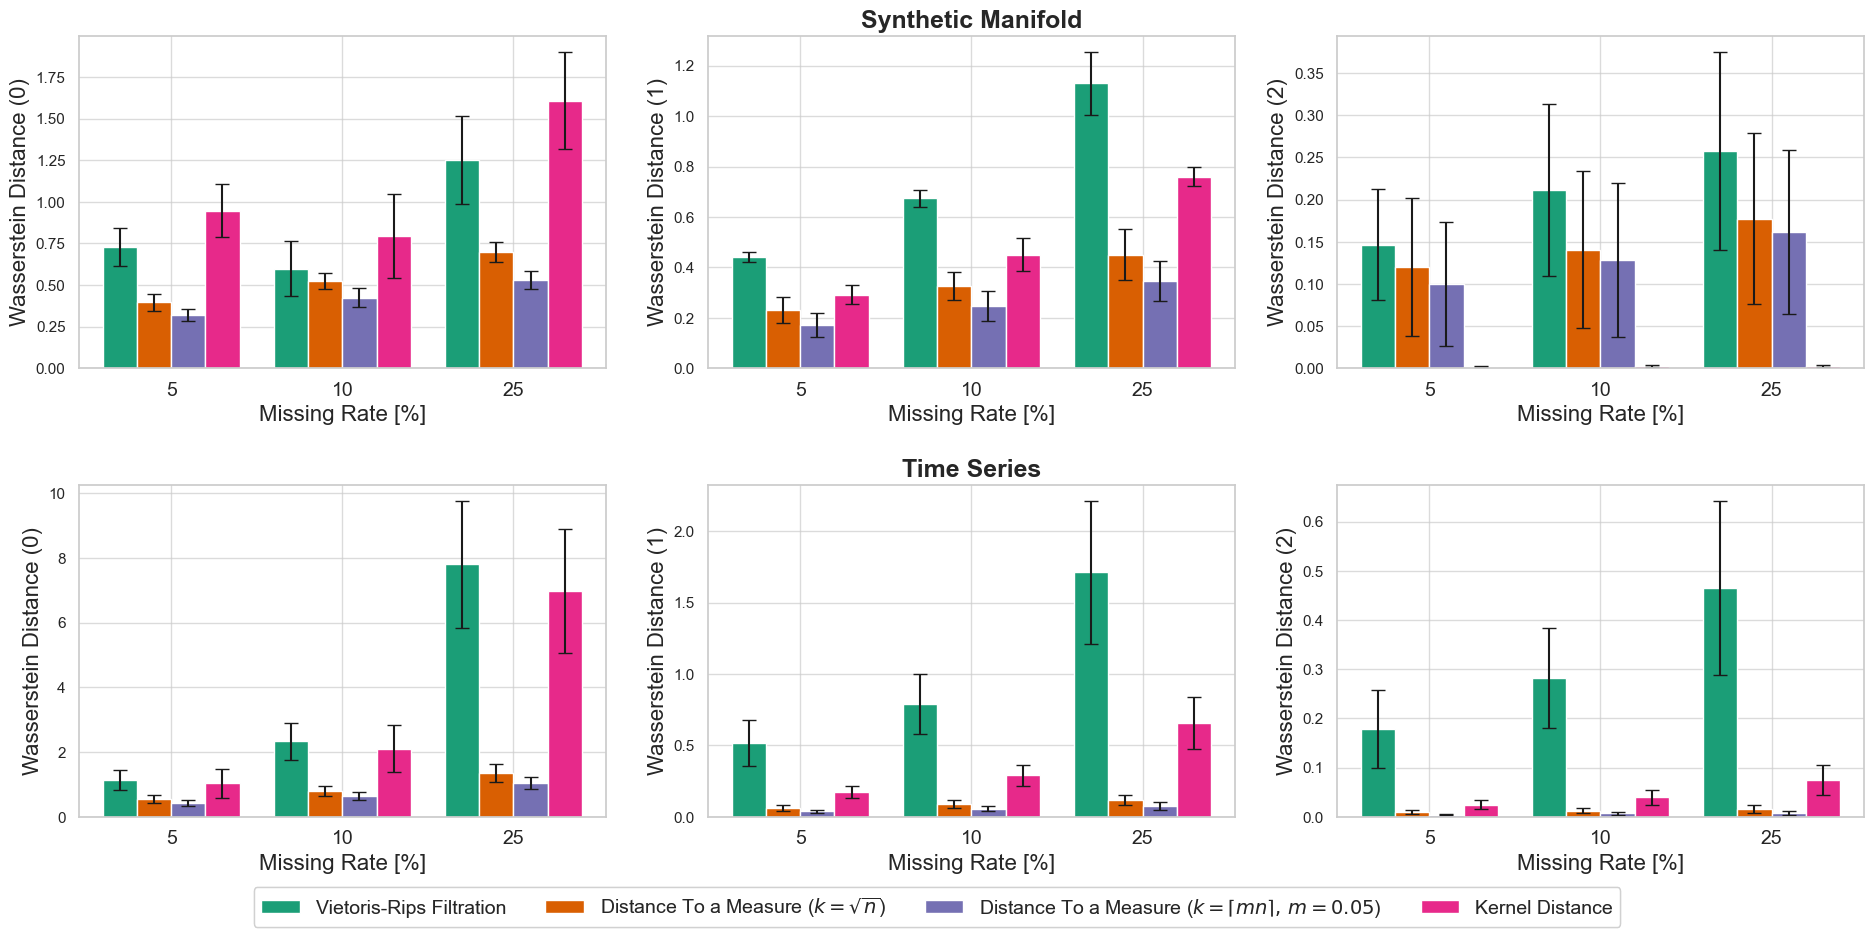

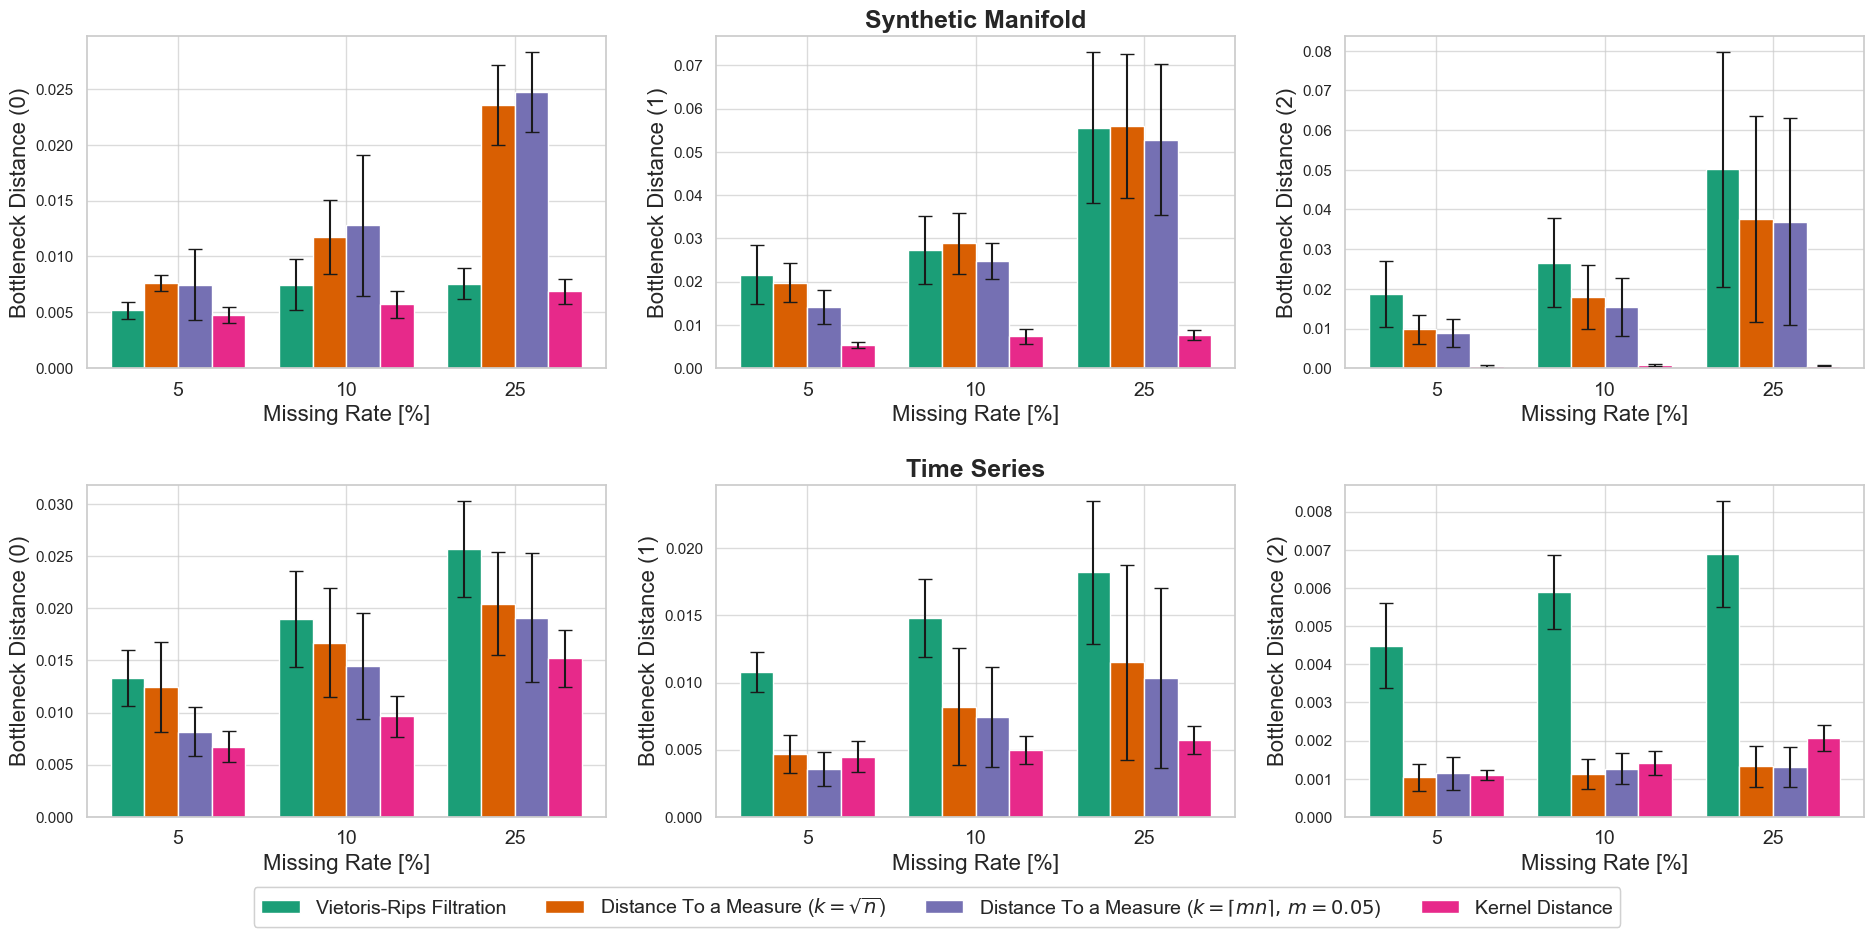

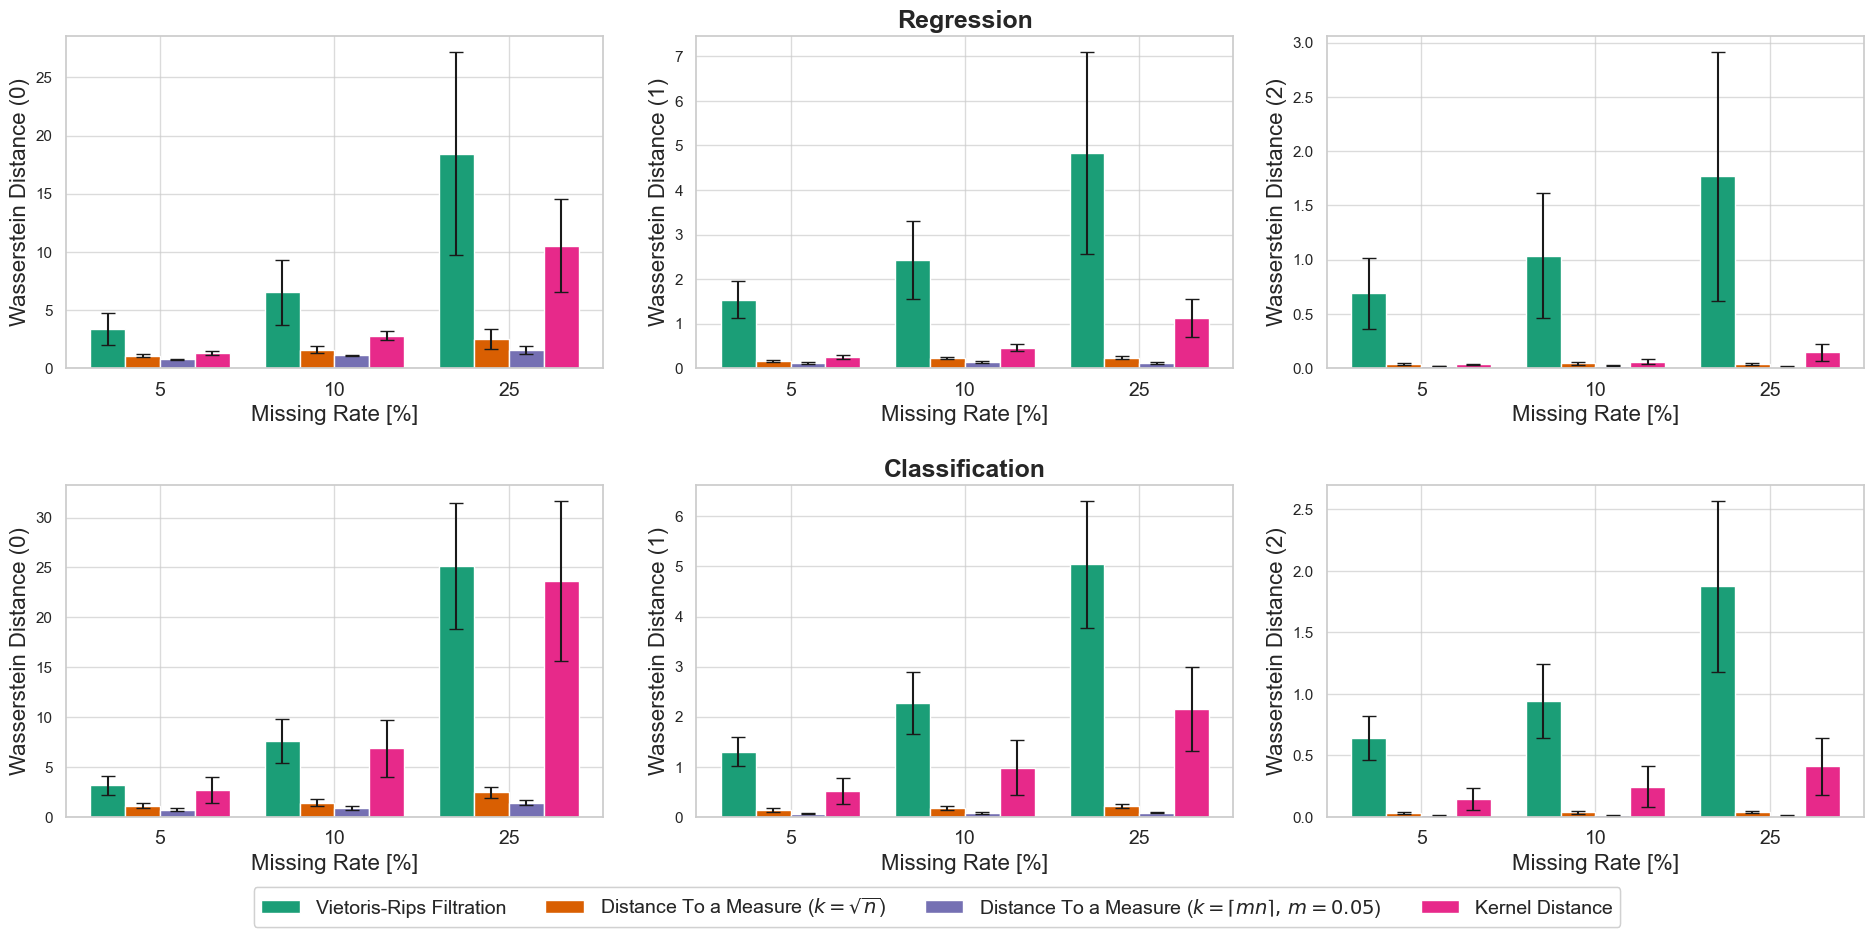

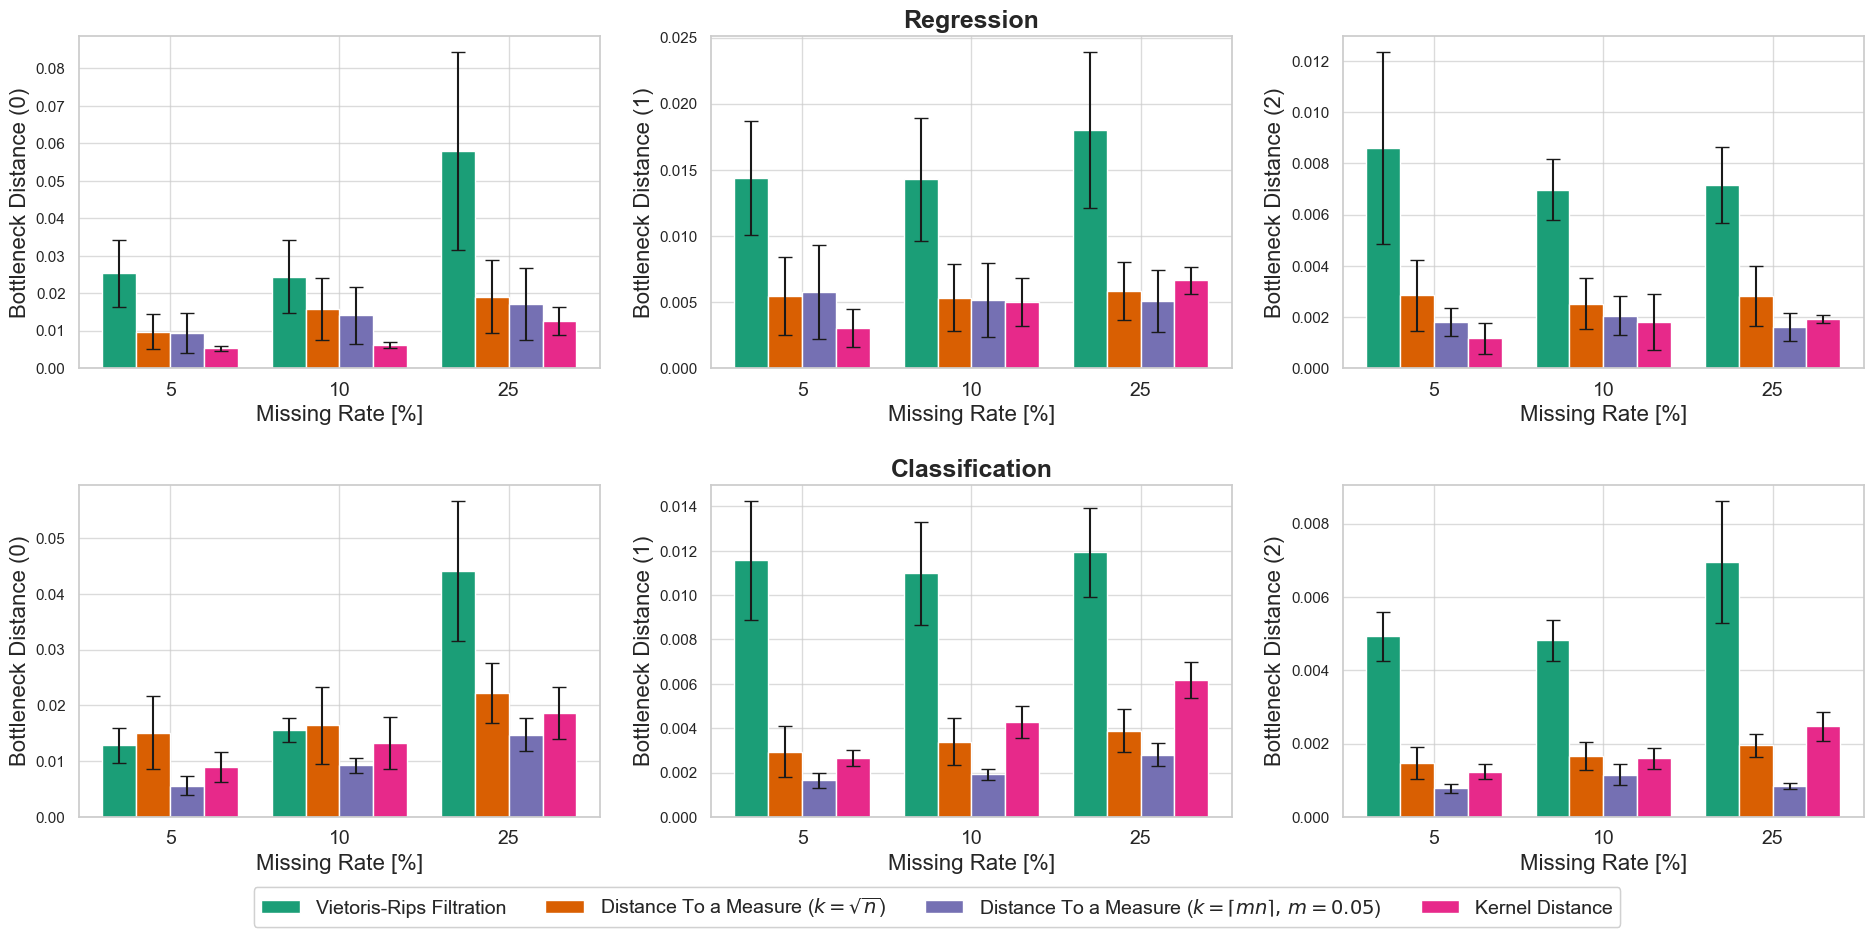

In [7]:
def filtration(dataset_types, suffix):
    df = group_results(
        csv=IMPACT_TDA,
        group=[DATASET, TDA_METHOD, DIMENSION, MISSING_RATE],
        metrics=COLLECTIONS[TDA_METRIC_SHORT]
    )

    for m, metric in enumerate(COLLECTIONS[TDA_METRIC_SHORT]):
        fig, axes = setup_figure(
            rows=len(dataset_types),
            cols=len(DIMENSIONS)
        )

        for i, dataset_type in enumerate(dataset_types):
            df_filtered = df[df[DATASET].isin(COLLECTIONS[dataset_type])].copy()

            for dim in DIMENSIONS:
                ax = axes[i][dim]
                df_stats, x, width = boxplot_stats(
                    df=df_filtered, 
                    filter=df_filtered[DIMENSION] == dim, 
                    group=[MISSING_RATE, TDA_METHOD], 
                    metric=metric,
                    steps=COLLECTIONS[MISSING_RATE], 
                    ticks=COLLECTIONS[TDA_METHOD]
                )

                for j, imp in enumerate(COLLECTIONS[TDA_METHOD]):
                    mean, sem = compute_mean_sem(
                        type=TDA_METHOD,
                        data=df_stats,
                        group=MISSING_RATE,
                        filter=df_stats[TDA_METHOD] == imp
                    )

                    format_axes(
                        type=TDA_METHOD, 
                        ax=ax,
                        x_label=LABEL[MISSING_RATE],
                        y_label=f'{LABEL[metric]} ({dim})',
                        ticks=x + width*(len(COLLECTIONS[TDA_METHOD])-1)/2,
                        tick_labels=COLLECTIONS[MISSING_RATE],
                        title=dim==1,
                        title_label=LABEL[dataset_type]
                    )
                    plot_data(
                        type=TDA_METHOD,
                        ax=ax, mean=mean, sem=sem,
                        label=LABEL[imp],
                        color=plt.get_cmap(COLOR_MAP[TDA_METHOD])(COLLECTIONS[TDA_METHOD].index(imp)),
                        x=x+j*width,
                        width=width
                    )

            legend(
                axes=axes[0],
                fig=fig, 
                cols=len(COLLECTIONS[TDA_METHOD]),
                bbox=(0.5, -0.05)
            )

        plot(fig, f'../figures/slides/tda_dataset_{topological_error[m]}{suffix}.svg')

filtration(FIRST, '_1')
filtration(SECOND, '_2')